MAPE table of 15 models
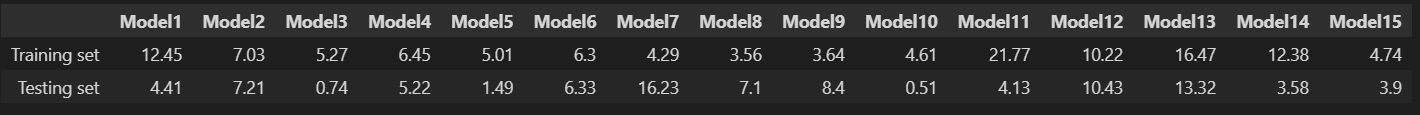

- Model building process <br>
<br>

The purpose of this case was to create a forecasting model that estimates Tiffany's quarterly sales. I made various prediction models such as the Regression models, Exponential model, and ARIMA models, starting with the naive model, which simply uses last quarter's sales as estimates.<br>
Before building a model, I drew a sales plot to check the trend and seasonality in sales. When sales deviate from existing trends and seasonality, I checked whether there is an exogenous effect that affects sales. I could see the additive increasing trend and sales spikes in every fourth quarter. <br>
Due to the effects of the 2008 financial crisis, sales deviated from the trend since the 2008 Q4. I made several variables related to the financial crisis and reflected them in the forecasting models to see whether the financial crisis had an abrupt effect and gradual effect on sales. <br>
I could see that the MAPE of the training set continued to decrease as the number of independent variables increased, but the MAPE of the testing set increased after a sudden point, resulting in a decrease in predictive power of the forecasting model. This is a problem that occurs as the model is overfitted in the training set.<br>
By comparing the training set and testing set MAPE of various regression models, I was able to check which variables are explanatory and which models are good models.<br>
Among the regression models, Model 3, which used Trend, Quarter, and abrupt change variables, showed the best predictive power (Testing MAPE of 0.74%).<br>
The Exponential model showed the best prediction performance when making a prediction model with additive trend and additive seasonality.<br>
Among ARIMA models, the Auto ARIMA with exogenous variable showed the best prediction performance. The best model identified through the compare_models function of the pycaret was the exponential smoothing model.



Q1. Install necessary libraries <br>
Q2. Load necessary libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from plotnine import *
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa.api import ExponentialSmoothing

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pmd
from pmdarima import model_selection

from sklearn.metrics import  mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

from pycaret.time_series import *

In [2]:
def mape(y_actual,y_predicted):
    return (round((abs(y_actual - y_predicted)/y_actual).mean()*100, 2))

In [3]:
def accuracy(y_actual,y_predicted,h=0):
    n_train = len(y_actual) - h
    accuracy_metrics = pd.DataFrame(columns=['MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(y_actual[:n_train],y_predicted[:n_train])
    if (h>0):
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(y_actual[n_train:],y_predicted[n_train:])
    return accuracy_metrics

### Case1: Forecasting quarterly net sales for Tiffany

Q3. Import the data

In [4]:
df = pd.read_excel('https://github.com/robertasgabrys/Forecasting/raw/main/TiffanySales.xlsx')
df.set_index(['Date'], inplace=True)
df.rename(columns={"Interest rate":"Interest"}, inplace=True)
df.head()

,Sales,CPI,GDP,DPI,Unemp,Interest
Date,,,,,,
2005-01-01,509901,190.733333,12816.2,9187.533333,5.300000,2.496667
2005-04-01,526701,191.933333,12975.7,9321.833333,5.100000,2.973333
2005-07-01,500105,194.500000,13206.5,9472.433333,4.966667,3.460000
2005-10-01,858446,196.866667,13383.3,9625.300000,4.966667,4.026667
2006-01-01,539241,197.866667,13649.8,9890.700000,4.733333,4.480000


Q4. Create a graph of each series and interpret the patterns you see. Which series are stationary? 


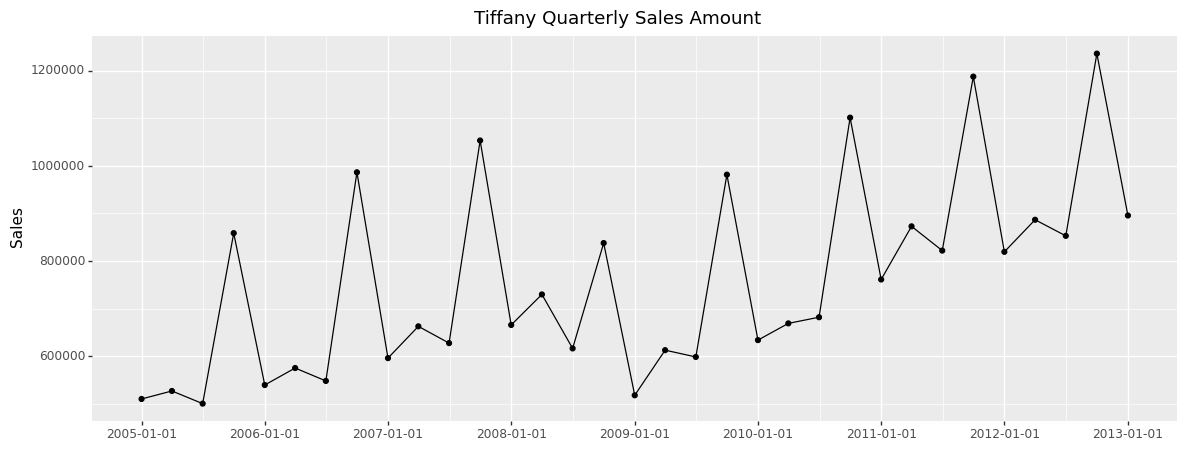

<ggplot: (135306081552)>

In [5]:
# Sales 

(ggplot(df, aes(df.index,'Sales')) + geom_point() + geom_line() 
+ labs(y = "Sales", title ="Tiffany Quarterly Sales Amount") 
+ theme(figure_size=(14,5))
)

Interpretation : <br>
- Sales data shows clear upward trend and seasonality pattern. Sales continued to increase over time, and I can see the seasonality of sales increasing in every fourth quarter.
- Thus, this series is not stationary


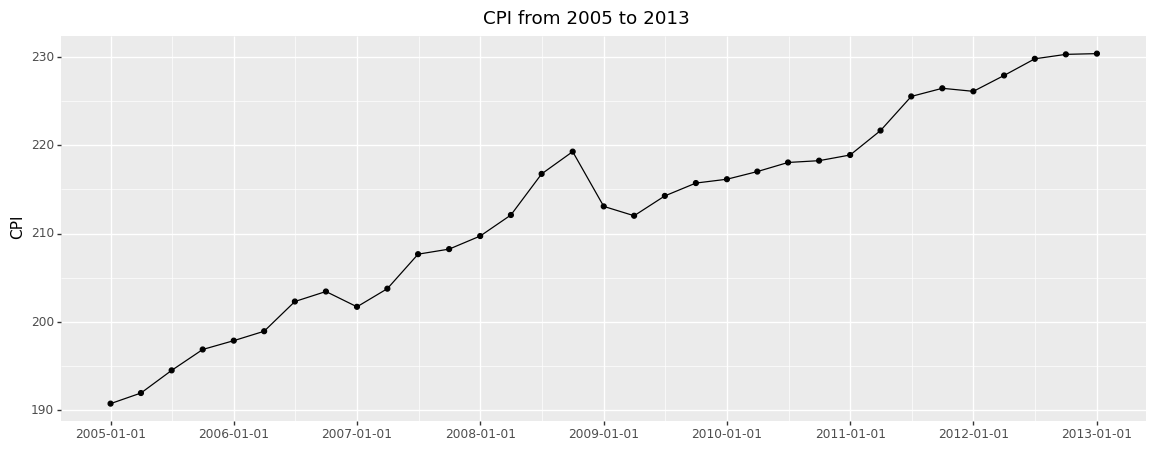

<ggplot: (135306164601)>

In [6]:
# CPI
(ggplot(df, aes(df.index,'CPI')) + geom_point() + geom_line() 
+ labs(y = "CPI", title ="CPI from 2005 to 2013") 
+ theme(figure_size=(14,5))
)

Interpretation : <br>
- CPI shows clear upward trend and no seasonality pattern. 
- This is non-stationary series

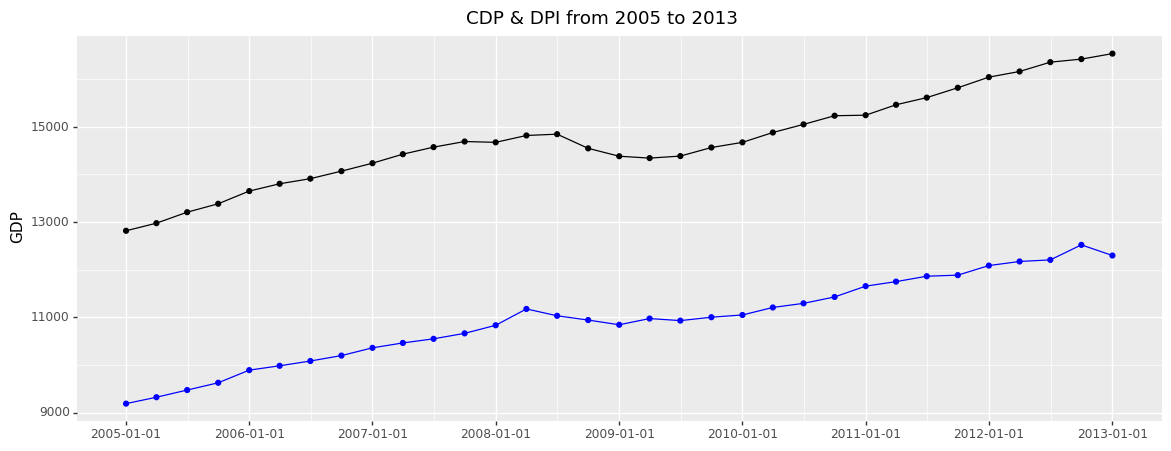

<ggplot: (135306498193)>

In [7]:
# GDP & DPI 
(ggplot(df, aes(df.index,'GDP')) + geom_point() + geom_line() 
+ geom_point(aes(df.index,'DPI'),color='Blue') + geom_line(aes(df.index,'DPI'),color='blue')
+ labs(title ="CDP & DPI from 2005 to 2013") 
+ theme(figure_size=(14,5))
)

Interpretation : <br>
- GDP shows clear upward trend and no seasonality pattern. This is non-stationary series<br>
- DPI shows clear upward trend and no seasonality pattern. This is non-stationary series

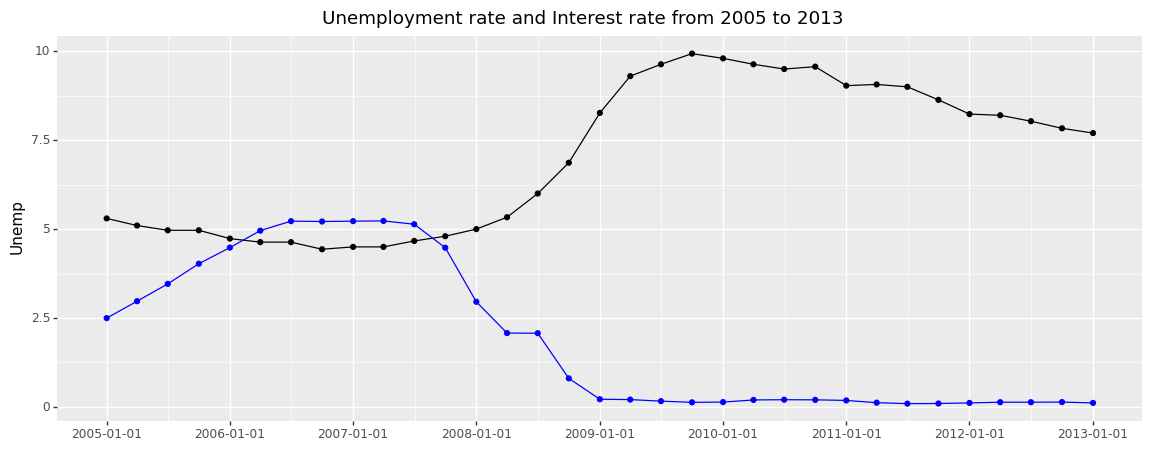

<ggplot: (135306348810)>

In [8]:
# Unemployment rate + Interest rate
(ggplot(df, aes(df.index,'Unemp')) + geom_point() + geom_line() 
+ geom_point(aes(df.index,'Interest'),color='Blue') + geom_line(aes(df.index,'Interest'),color='blue')
+ labs(title ="Unemployment rate and Interest rate from 2005 to 2013") 
+ theme(figure_size=(14,5))
)

Interpretation : <br>
- Unemployment rate is economic data. The unemployment rate(blue line) gradually decreased from 2005 and then reached the low point in the 2007 Q1 and gradually increased again after 2008, peaked in the 2009 Q3, and gradually decreased again. This is non-stationary series <br>
- Interest rate shows the opposite pattern to unemployment. The interest rate gradually rise from 2005, reached a peak in the 2007 Q1, fell sharply from the 2007 Q4, and then reached a low point in 2009. This is non-stationary series


Q5. Divide sales data into training and testing sets: last 4 data points represent your testing set.

In [9]:
# Make some features for prediction

df['Trend'] = list(range(1, df.shape[0]+1))
df['Quarter'] = df.index.quarter

# To assess the abrupt change in Sales, we need to create a dummy variable
# FC = 0 before crisis and 1 after
df['FC'] = 0 
df.loc['2008-04-01':, 'FC'] = 1

# To assess the abrupt change in Sales, we need to create a dummy variable
# FC_temp = 0 no crisis and 1 temporary crisis
df['FC_temp'] = 0
df.loc['2008-04-01':'2009-04-01', 'FC_temp'] = 1

# Create Ramp1 varibale to model gradual effect of financial crisis on Sales
df['Ramp1'] = 0
df.loc['2008-04-01':, 'Ramp1'] = list(range(1, 21))

# Create Ramp1 varibale to model gradual effect of financial crisis on Sales
df['Ramp1_qaud'] = df['Ramp1'] **2

# Create Ramp2 varibale to model gradual effect on Sales
df['Ramp2'] = 0
df.loc['2009-07-01':, 'Ramp2'] = list(range(1, 16))

In [10]:
# Divide sales data into training and testing sets 

train_data = df.loc['2005-01-01':'2012-01-01']
test_data = df.loc['2012-04-01':'2013-01-01']

Q6. Build the following models to predict Tiffany’s quarterly sales: <br>
<br>
Model 1: seasonal naïve model <br>
Q1 prediction = previous year’s Q1 value, Q2 prediction = previous year’s Q2 value, etc. <br>

In [11]:
# Seasonal naive model

df['M1'] = np.nan
for i in range(4, len(df)):
    df['M1'].iloc[i] = df['Sales'].iloc[i-4] 
df.tail(8)

,Sales,CPI,GDP,DPI,Unemp,Interest,Trend,Quarter,FC,FC_temp,Ramp1,Ramp1_qaud,Ramp2,M1
Date,,,,,,,,,,,,,,
2011-04-01,872712,221.666333,15461.9,11748.600000,9.066667,0.120000,26,2,1,0,13,169,8,668760.0
2011-07-01,821767,225.530667,15611.8,11862.033333,9.000000,0.093333,27,3,1,0,14,196,9,681729.0
2011-10-01,1187440,226.452000,15818.7,11884.833333,8.633333,0.096667,28,4,1,0,15,225,10,1101215.0
2012-01-01,819170,226.107667,16041.6,12085.733333,8.233333,0.113333,29,1,1,0,16,256,11,761018.0
2012-04-01,886569,227.906667,16160.4,12171.833333,8.200000,0.133333,30,2,1,0,17,289,12,872712.0
2012-07-01,852741,229.792667,16356.0,12205.133333,8.033333,0.133333,31,3,1,0,18,324,13,821767.0
2012-10-01,1235769,230.296667,16420.3,12520.366667,7.833333,0.136667,32,4,1,0,19,361,14,1187440.0
2013-01-01,895484,230.379667,16535.3,12296.866667,7.700000,0.113333,33,1,1,0,20,400,15,819170.0


In [12]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M1'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M1'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model1 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model1 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [13]:
# b. Report MAPE on the training and testing sets

Model1_mape = accuracy(df['Sales'], df['M1'], h=4)
Model1_mape


,MAPE(%)
Training set,12.45
Testing set,4.41


C. Is your model adequate? Briefly explain. <br>
<br>
This model is not adequate. This is a prediction based on the naive assumption that sales will be the same as sales in the same quarter of the previous year.
The MAPE of Testing set is 4.41%, which is not bad, but we can use additional information to make more accurate sales forecasts.

Q7. Model 2: regression model that captures linear trend and annual seasonality. <br>
You need to create these features and build a model.

In [14]:
# Make some features for prediction

df['Trend'] = list(range(1, df.shape[0]+1))
df['Quarter'] = df.index.quarter

In [15]:
train_data.head()

,Sales,CPI,GDP,DPI,Unemp,Interest,Trend,Quarter,FC,FC_temp,Ramp1,Ramp1_qaud,Ramp2
Date,,,,,,,,,,,,,
2005-01-01,509901,190.733333,12816.2,9187.533333,5.300000,2.496667,1,1,0,0,0,0,0
2005-04-01,526701,191.933333,12975.7,9321.833333,5.100000,2.973333,2,2,0,0,0,0,0
2005-07-01,500105,194.500000,13206.5,9472.433333,4.966667,3.460000,3,3,0,0,0,0,0
2005-10-01,858446,196.866667,13383.3,9625.300000,4.966667,4.026667,4,4,0,0,0,0,0
2006-01-01,539241,197.866667,13649.8,9890.700000,4.733333,4.480000,5,1,0,0,0,0,0


In [16]:
# Model2 : Regression model with linear trend + annual seasonality

M2 = smf.ols('Sales ~ Trend + C(Quarter)', data = train_data).fit()
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     46.34
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           5.99e-11
Time:                        16:40:06   Log-Likelihood:                -361.91
No. Observations:                  29   AIC:                             733.8
Df Residuals:                      24   BIC:                             740.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.771e+05    3.4e+04     

In [17]:
df['M2'] = M2.predict(df)

In [18]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M2'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M2'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model2 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model2 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [19]:
# b. Report MAPE on the training and testing sets

Model2_mape = accuracy(df['Sales'], df['M2'], h=4)
Model2_mape


,MAPE(%)
Training set,7.03
Testing set,7.21


In [20]:
Mape_table = Model1_mape.merge(Model2_mape, how='left', on=Model1_mape.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.columns = ['Model1', 'Model2']
Mape_table.index = ['Training set', 'Testing set']
Mape_table

,Model1,Model2
Training set,12.45,7.03
Testing set,4.41,7.21


C. Is your model adequate? Briefly explain. <br>
<br>
This model is adequate but not enough. The predictive power of the model improved by reflecting the trend of increasing sales and quarterly seasonality in the prediction. <br>
The MAPE of the training set is 7.03%, which is significantly improved compared to the previous model. However, the MAPE of the Testing set is higher than that of the previous model.

Q8. Model 3: regression model that captures linear trend, annual seasonality and abrupt change starting 2008-04-01 (You noticed that there was a decline in sales because of financial crisis).

In [21]:
# To assess the abrupt change in Sales, we need to create a dummy variable
# FC = 0 before crisis and 1 after

df['FC'] = 0
df.loc['2008-04-01':, 'FC'] = 1

In [22]:
# Model3 : Regression model with linear trend, annual seasonality, abrupt change starting 2008-04-01

M3 = smf.ols('Sales ~ Trend + C(Quarter) + FC', data = train_data).fit()
print(M3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     70.29
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.65e-13
Time:                        16:40:06   Log-Likelihood:                -352.86
No. Observations:                  29   AIC:                             717.7
Df Residuals:                      23   BIC:                             725.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.292e+05   2.76e+04     

In [23]:
df['M3'] = M3.predict(df)

In [24]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M3'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M3'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model3 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model3 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [25]:
# b. Report MAPE on the training and testing sets

Model3_mape = accuracy(df['Sales'], df['M3'], h=4)
Model3_mape

,MAPE(%)
Training set,5.27
Testing set,0.74


In [26]:
Mape_table = Mape_table.merge(Model3_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3']
Mape_table

,Model1,Model2,Model3
Training set,12.45,7.03,5.27
Testing set,4.41,7.21,0.74


C. Is your model adequate? Briefly explain. <br>
<br>
This model is adequate. The predictive power of the model increased by reflecting the trend of increasing sales, quarterly seasonality, and the abrupt impact of the 2008 financial crisis in the forecast. <br>
The MAPE of the training set and testing set was 5.27% and 0.74% respectively, which was improved compared to the previous model.

Q9. Model 4: regression model that captures linear trend, annual seasonality and and temporary abrupt change starting 2008-04-01 and ending 2009-04-01 (both start and end points are included).

In [27]:
# To assess the abrupt change in Sales, we need to create a dummy variable
# FC_temp = 0 no crisis and 1 temporary crisis

df['FC_temp'] = 0
df.loc['2008-04-01':'2009-04-01', 'FC_temp'] = 1

In [28]:
# Model4 : Regression model with linear trend, annual seasonality, temparary abrupt change

M4 = smf.ols('Sales ~ Trend + C(Quarter) + FC_temp', data = train_data).fit()
print(M4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     48.05
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.02e-11
Time:                        16:40:06   Log-Likelihood:                -357.97
No. Observations:                  29   AIC:                             727.9
Df Residuals:                      23   BIC:                             736.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.838e+05   3.04e+04     

In [29]:
df['M4'] = M4.predict(df)

In [30]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M4'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M4'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model4 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model4 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [31]:
# b. Report MAPE on the training and testing sets

Model4_mape = accuracy(df['Sales'], df['M4'], h=4)
Model4_mape

,MAPE(%)
Training set,6.45
Testing set,5.22


In [32]:
Mape_table = Mape_table.merge(Model4_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4']
Mape_table

,Model1,Model2,Model3,Model4
Training set,12.45,7.03,5.27,6.45
Testing set,4.41,7.21,0.74,5.22


C. Is your model adequate? Briefly explain. <br>
<br>
This model is adequate but not enough. The model was created by reflecting the trend of increasing sales, quarterly seasonality, and the temporary impact of the 2008 financial crisis in the forecast.
The MAPE of the training set and testing set was 6.45% and 5.22%, respectively, which was worse than the previous model.

Q10. Model 5: regression model that captures linear trend, annual seasonality and abrupt change starting 2008-04-01 + Ramp starting 2008-04-01

In [33]:
# Model5 : Regression model with linear trend, annual seasonality, abrupt change starting 2008-04-01, Gradual change starting 2008-04-01

M5 = smf.ols('Sales ~ Trend + C(Quarter) + FC + Ramp1', data = train_data).fit()
print(M5.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     57.25
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           2.62e-12
Time:                        16:40:07   Log-Likelihood:                -352.57
No. Observations:                  29   AIC:                             719.1
Df Residuals:                      22   BIC:                             728.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.432e+05   3.49e+04     

In [34]:
df['M5'] = M5.predict(df)

In [35]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M5'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M5'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model5 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model5 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [36]:
# b. Report MAPE on the training and testing sets

Model5_mape = accuracy(df['Sales'], df['M5'], h=4)
Model5_mape

,MAPE(%)
Training set,5.01
Testing set,1.49


In [37]:
Mape_table = Mape_table.merge(Model5_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5']
Mape_table

,Model1,Model2,Model3,Model4,Model5
Training set,12.45,7.03,5.27,6.45,5.01
Testing set,4.41,7.21,0.74,5.22,1.49


C. Is your model adequate? Briefly explain. <br>
<br>
This model is adequate. The model was created by reflecting the trend of increasing sales, quarterly seasonality, and abrupt and gradual changes caused by the 2008 financial crisis in the forecast.
The MAPE of the training set and testing set is good at 5.01% and 1.49%, respectively.

Q11. Model 6: regression model that captures linear trend, annual seasonality and and temporary abrupt change starting 2008-04-01 and ending 2009-04-01 (both start and end points are included) + Ramp starting 2008-04-01.

In [38]:
# Model6 : Regression model with linear trend, annual seasonality, temparary abrupt change, gradual change

M6 = smf.ols('Sales ~ Trend + C(Quarter) + FC_temp + Ramp1', data = train_data).fit()
print(M6.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     38.74
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.33e-10
Time:                        16:40:07   Log-Likelihood:                -357.82
No. Observations:                  29   AIC:                             729.6
Df Residuals:                      22   BIC:                             739.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.714e+05   4.04e+04     

In [39]:
df['M6'] = M6.predict(df)

In [40]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M6'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M6'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model6 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model6 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [41]:
# b. Report MAPE on the training and testing sets

Model6_mape = accuracy(df['Sales'], df['M6'], h=4)
Model6_mape

,MAPE(%)
Training set,6.3
Testing set,6.33


In [42]:
Mape_table = Mape_table.merge(Model6_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6
Training set,12.45,7.03,5.27,6.45,5.01,6.3
Testing set,4.41,7.21,0.74,5.22,1.49,6.33


C. Is your model adequate? Briefly explain. <br>
<br>
This model is adequate. The model was created by reflecting the trend of increasing sales, quarterly seasonality, and temporary abrupt change and gradual change caused by the 2008 financial crisis in the forecast.
The MAPE of the training set and testing set was 6.3% and 6.33%, respectively. This model has a worse predictive power compared to previous best models.

Q12. Model 7: regression model that captures linear trend, annual seasonality, abrupt change starting 2008-04-01, linear and quadratic Ramp starting 2008-04-01

In [43]:
# Model7 : Regression model with linear trend, annual seasonality, abrupt change starting 2008-04-01, linear and quadratic ramps starting 2008-04-01

M7 = smf.ols('Sales ~ Trend + C(Quarter) + FC + Ramp1 + Ramp1_qaud', data = train_data).fit()
print(M7.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     67.02
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           6.15e-13
Time:                        16:40:07   Log-Likelihood:                -347.64
No. Observations:                  29   AIC:                             711.3
Df Residuals:                      21   BIC:                             722.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.426e+05   3.02e+04     

In [44]:
df['M7'] = M7.predict(df)

In [45]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M7'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M7'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model7 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model7 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [46]:
# b. Report MAPE on the training and testing sets

Model7_mape = accuracy(df['Sales'], df['M7'], h=4)
Model7_mape

,MAPE(%)
Training set,4.29
Testing set,16.23


In [47]:
Mape_table = Mape_table.merge(Model7_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6,Model7
Training set,12.45,7.03,5.27,6.45,5.01,6.3,4.29
Testing set,4.41,7.21,0.74,5.22,1.49,6.33,16.23


C. Is your model adequate? Briefly explain. <br>
<br>
This model is not adequate. This model was created by adding quadratic gradual effect to Model 5. By adding the quadratic gradual effect to the model, the MAPE and R-sqaured values of the training set improved compared to the Model5, but the MAPE of the testing set deteriorated significantly to 16.23%. This model is an overfitted model in the training set.

Q13. Model 8 : regression Model 4 (linear trend, annual seasonality, temp abrupt change) + Ramp 1 starting 2008-04-01 + Ramp 2 starting 2009-07-01

In [48]:
# Model8 : Regression model with linear trend, annual seasonality, Temp abrupt change, Ramp1, Ramp2

M8 = smf.ols('Sales ~ Trend + C(Quarter) + FC_temp + Ramp1 + Ramp2', data = train_data).fit()
print(M8.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     103.5
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           7.82e-15
Time:                        16:40:08   Log-Likelihood:                -341.57
No. Observations:                  29   AIC:                             699.1
Df Residuals:                      21   BIC:                             710.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.438e+05    2.4e+04     

In [49]:
df['M8'] = M8.predict(df)

In [50]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M8'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M8'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model8 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model8 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [51]:
# b. Report MAPE on the training and testing sets

Model8_mape = accuracy(df['Sales'], df['M8'], h=4)
Model8_mape

,MAPE(%)
Training set,3.56
Testing set,7.1


In [52]:
Mape_table = Mape_table.merge(Model8_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
Training set,12.45,7.03,5.27,6.45,5.01,6.3,4.29,3.56
Testing set,4.41,7.21,0.74,5.22,1.49,6.33,16.23,7.1


C. Is your model adequate? Briefly explain. <br>
<br>
This model is not adequate. This model was created by using sales growth trends, quarterly seasonality, temporary abrupt effect caused by the 2008 financial crisis, and gradual effect 1 and 2 as variables.
The MAPE of the training set showed the best performance at 3.56%, but the MAPE of the testing set was 7.1% which was lower than other models. This model can also be seen as overfitting using too many variables.

Q14. Model 9: regression model (linear trend, annual seasonality, abrupt change, Ramp1, Ramp2)

In [53]:
M9 = smf.ols('Sales ~ Trend + C(Quarter) + FC + Ramp1 + Ramp2', data = train_data).fit()
print(M9.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     95.77
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.71e-14
Time:                        16:40:08   Log-Likelihood:                -342.65
No. Observations:                  29   AIC:                             701.3
Df Residuals:                      21   BIC:                             712.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.459e+05   2.54e+04     

In [54]:
df['M9'] = M9.predict(df)

In [55]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M9'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M9'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model9 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model9 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [56]:
# b. Report MAPE on the training and testing sets

Model9_mape = accuracy(df['Sales'], df['M9'], h=4)
Model9_mape

,MAPE(%)
Training set,3.64
Testing set,8.4


In [57]:
Mape_table = Mape_table.merge(Model9_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9
Training set,12.45,7.03,5.27,6.45,5.01,6.3,4.29,3.56,3.64
Testing set,4.41,7.21,0.74,5.22,1.49,6.33,16.23,7.1,8.4


C. Is your model adequate? Briefly explain. <br>
<br>
This model is not adequate. This model was created by using sales growth trends, quarterly seasonality, and abrupt effect and gradual effect 1 and 2 caused by the 2008 financial crisis as variables.
Like Model 8, the training set's MAPE showed good performance of 3.64%, but the testing set's MAPE was 8.4%, which was worse than the previous models. This model can also be seen as overfitting using too many variables.

Q15. Model 10 : Exponential smoothing model. Determine the optimal setting that gives most accurate prediction.  

In [58]:
# Find the optimal setting that give the lowest MAPE value

yhat = test_data.copy()

temp_MAPE = []

for i in ['add', 'mul']:
    for j in ['add', 'mul']:
        # fit a Holt Winters Seasonal model
        fit = ExponentialSmoothing(train_data['Sales'],
                                   seasonal_periods = 4,
                                   trend = i,
                                   seasonal = j).fit()

        # forecast using the model
        yhat['HoltWinters'] = fit.forecast(len(test_data))
        temp_MAPE.append([i,j, (mean_absolute_percentage_error(test_data['Sales'], yhat['HoltWinters']))])
        
temp_MAPE
        

[['add', 'add', 0.005145261213307029],
 ['add', 'mul', 0.03900941827759005],
 ['mul', 'add', 0.013890683927271526],
 ['mul', 'mul', 0.036776485518016995]]

In [59]:
# Build exponential smoothing model to model linear trend and seasonality
# The lowest MAPE is when we have trend = 'add', seasonality = 'add'

M10 = ExponentialSmoothing(train_data['Sales'], trend='add', seasonal='add', seasonal_periods=4, initialization_method='estimated', missing='drop').fit()
print(M10.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   29
Model:             ExponentialSmoothing   SSE                    57534562811.659
Optimized:                         True   AIC                            636.842
Trend:                         Additive   BIC                            647.781
Seasonal:                      Additive   AICC                           649.065
Seasonal Periods:                     4   Date:                 Sun, 11 Dec 2022
Box-Cox:                          False   Time:                         16:40:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9950000                alpha                 True
smoothing_trend          

In [60]:
df.loc[:'2012-01-01', 'M10'] = M10.fittedvalues
df.loc['2012-04-01':, 'M10'] = M10.forecast(4)

In [61]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M10'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M10'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model10 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model10 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [62]:
# b. Report MAPE on the training and testing sets

Model10_mape = accuracy(df['Sales'], df['M10'], h=4)
Model10_mape

,MAPE(%)
Training set,4.61
Testing set,0.51


In [63]:
Mape_table = Mape_table.merge(Model10_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9', 'Model10']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9,Model10
Training set,12.45,7.03,5.27,6.45,5.01,6.3,4.29,3.56,3.64,4.61
Testing set,4.41,7.21,0.74,5.22,1.49,6.33,16.23,7.1,8.4,0.51


C. Is your model adequate? Briefly explain. <br>
<br>
This model is adequate. This model is a Holt-Winters Exponential smoothing model that reflects the additional trend and the additional quarterly seasonality.
Compared to all previous models, the MAPE value of the Testing set was the lowest, and the MAPE of the Training set was also at a fairly good level.

Q16. Model 11 : Auto ARIMA model. Max p+q+P+Q <=2 , d+D <=2

In [64]:
# Build Auto ARIMA model max_order <=2, max_d + max_D <= 2

train, test = model_selection.train_test_split(df['Sales'], test_size=4)

step_fit = pmd.auto_arima(train, start_p = 0, start_d = 0, start_q = 0, max_p = 2, max_d = 1, max_q = 2, start_P= 0, start_D = 0, start_Q = 0, 
                   max_P = 2, max_D = 1, max_Q = 2, max_order= 2, trace=True, seasonal=True, m=4, stepwise=False)


 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=646.708, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=648.681, Time=0.02 sec
 ARIMA(0,0,0)(0,1,2)[4] intercept   : AIC=650.498, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=648.687, Time=0.02 sec
 ARIMA(0,0,0)(1,1,1)[4] intercept   : AIC=650.675, Time=0.04 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=650.515, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=646.478, Time=0.01 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=648.460, Time=0.03 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=648.472, Time=0.11 sec
 ARIMA(0,0,2)(0,1,0)[4] intercept   : AIC=650.437, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=653.386, Time=0.01 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=655.380, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=655.384, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=654.305, Time=0.04 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=655.722, Time=0.02 sec

Best model:  ARIMA(0,0,1

In [65]:
# Best ARIMA model from Auto ARIMA : ARIMA(0,0,1)(0,1,0)[4] model

M11 = sm.tsa.statespace.SARIMAX(train_data['Sales'], order=(0,0,1), seasonal_order=(0,1,0,4)).fit()

print(M11.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   29
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 4)   Log Likelihood                -322.426
Date:                            Sun, 11 Dec 2022   AIC                            648.851
Time:                                    16:40:10   BIC                            651.289
Sample:                                01-01-2005   HQIC                           649.527
                                     - 01-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2256      0.075      3.020      0.003       0.079       0.372
sigma2      8.109e+09   2.32e-13   

In [66]:
df['M11'] = M11.predict(0, len(df)-1, dynamic=False, type='levels')


In [67]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M11'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M11'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model11 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model11 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [68]:
# b. Report MAPE on the training and testing sets

Model11_mape = accuracy(df['Sales'], df['M11'], h=4)
Model11_mape

,MAPE(%)
Training set,21.77
Testing set,4.13


In [69]:
Mape_table = Mape_table.merge(Model11_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9', 'Model10','Model11']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9,Model10,Model11
Training set,12.45,7.03,5.27,6.45,5.01,6.3,4.29,3.56,3.64,4.61,21.77
Testing set,4.41,7.21,0.74,5.22,1.49,6.33,16.23,7.1,8.4,0.51,4.13


C. Is your model adequate? Briefly explain. <br>
<br>
This model is adequate. A forecasting model was created using the autocorrelation of data using the Auto ARIMA function. In this model, the MAPE of the training set is not good because the fitted value is not good at the beginning of the training data. The MAPE of the Testing set is 4.13% which is adequate, but not as good as the regression model or the exposure model I made earlier.

Q17. Model 12: select the most accurate model among Models 2 to 9 and dump its features into auto arima

The best regression model is Model3 because the model has the best Testing set MAPE value. The model has variables of trend, Quarterly seasonality, and abrupt change effect(FC).   

In [70]:
exogeneous_features = train_data[['Trend', 'Quarter', 'FC']]

step_fit = pmd.auto_arima(train_data['Sales'], X=exogeneous_features, start_p = 0, start_d = 0, start_q = 0, max_p = 2, max_d = 1, max_q = 2, start_P= 0, start_D = 0, start_Q = 0, 
                   max_P = 2, max_D = 1, max_Q = 2, max_order= 2, trace=True, seasonal=True, m=4, stepwise=False)

 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=775.679, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=769.757, Time=0.04 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=770.269, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=767.152, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=769.129, Time=0.06 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=769.065, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=777.144, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=768.461, Time=0.07 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=764.102, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[4] intercept   : AIC=778.436, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=778.922, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=769.498, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=764.870, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=779.267, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=772.863, Time=0.03 sec

Best model:  ARIMA(0,0,1

In [71]:
# Best ARIMA model from Auto ARIMA : ARIMA(0,0,1)(1,0,0)[4] model

M12 = sm.tsa.statespace.SARIMAX(train_data['Sales'], order=(0,0,1), seasonal_order=(1,0,0,4), exog=exogeneous_features).fit()

print(M12.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   29
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 4)   Log Likelihood                -375.169
Date:                            Sun, 11 Dec 2022   AIC                            762.339
Time:                                    16:40:11   BIC                            770.543
Sample:                                01-01-2005   HQIC                           764.908
                                     - 01-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Trend       3.243e+04   1.32e+04      2.463      0.014    6617.846    5.82e+04
Quarter     1.562e+05   8.29e+04   

In [72]:
exogeneous_features_test = df.loc['2012-04-01':,['Trend','Quarter', 'FC']]

df.loc[:'2012-01-01', 'M12'] = M12.predict(0, len(train_data)-1, exog=exogeneous_features)
df.loc['2012-04-01':, 'M12'] = M12.predict(len(train_data), len(train_data)+len(test_data)-1, exog=exogeneous_features_test)

In [73]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M12'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M12'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model12 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model12 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [74]:
# b. Report MAPE on the training and testing sets

Model12_mape = accuracy(df['Sales'], df['M12'], h=4)
Model12_mape

,MAPE(%)
Training set,10.22
Testing set,10.43


In [75]:
Mape_table = Mape_table.merge(Model12_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9', 'Model10','Model11', 'Model12']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9,Model10,Model11,Model12
Training set,12.45,7.03,5.27,6.45,5.01,6.3,4.29,3.56,3.64,4.61,21.77,10.22
Testing set,4.41,7.21,0.74,5.22,1.49,6.33,16.23,7.1,8.4,0.51,4.13,10.43


C. Is your model adequate? Briefly explain. <br>
<br>
This model is not adequate. This prediction model was created using the auto-correlation of data and exogenous variables found in the regression model using the Auto ARIMA function.
This ARIMAX model is not an effective model because the MAPE of the training set and testing set is very high at 10% level.

Q18. Model 13: Regression that predicts sales from exogenous variables, CPI, GDP DPI, Unemp, Interest rate.

13-1. use auto arima function to predict exogenous variables <br> 
13-2. You may explore and identify the best variables for the model

In [76]:
# Make a dataframe for exogenous variable prediction
test_exo = pd.DataFrame({'CPI':[0,0,0,0], 'Date':['2012-04-01','2012-07-01','2012-10-01', '2013-01-01']})
test_exo.set_index('Date', inplace=True)

In [77]:
# 13-1 predict exogeneous variables_CPI
cpi_fit = pmd.auto_arima(train_data['CPI'], start_p = 0, start_d = 0, start_q = 0, max_p = 2, max_d = 1, max_q = 2, start_P= 0, start_D = 0, start_Q = 0, 
                   max_P = 2, max_D = 1, max_Q = 2, max_order= 2, trace=True, seasonal=True, m=4, stepwise=False)
M_cpi = sm.tsa.statespace.SARIMAX(train_data['CPI'], order=(0,1,2), seasonal_order=(0,0,0,4)).fit()
test_exo['CPI'] = M_cpi.forecast(4)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=123.070, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=124.254, Time=0.04 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=124.741, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=123.843, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=121.663, Time=0.19 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=123.740, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=120.486, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=122.196, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=122.045, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=116.758, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=124.494, Time=0.01 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=125.582, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=125.067, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=120.152, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=117.218, Time=0.03 sec

Best model:  ARIMA(0,1,2

In [78]:
# 13-1 predict exogeneous variables_GDP
GDP_fit = pmd.auto_arima(train_data['GDP'], start_p = 0, start_d = 0, start_q = 0, max_p = 2, max_d = 1, max_q = 2, start_P= 0, start_D = 0, start_Q = 0, 
                   max_P = 2, max_D = 1, max_Q = 2, max_order= 2, trace=True, seasonal=True, m=4, stepwise=False)
M_GDP = sm.tsa.statespace.SARIMAX(train_data['GDP'], order=(1,1,0), seasonal_order=(0,0,0,4)).fit()
test_exo['GDP'] = M_GDP.forecast(4)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=352.826, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=354.506, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=355.725, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=354.566, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=356.510, Time=0.03 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=356.040, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=347.482, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=349.248, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=349.301, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=347.091, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=344.207, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=346.166, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=346.172, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=345.989, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=345.962, Time=0.04 sec

Best model:  ARIMA(1,1,0

In [79]:
# 13-1 predict exogeneous variables_DPI
DPI_fit = pmd.auto_arima(train_data['DPI'], start_p = 0, start_d = 0, start_q = 0, max_p = 2, max_d = 1, max_q = 2, start_P= 0, start_D = 0, start_Q = 0, 
                   max_P = 2, max_D = 1, max_Q = 2, max_order= 2, trace=True, seasonal=True, m=4, stepwise=False)
M_DPI = sm.tsa.statespace.SARIMAX(train_data['DPI'], order=(0,1,0), seasonal_order=(0,0,1,4)).fit()
test_exo['DPI'] = M_DPI.forecast(4)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=343.212, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=342.753, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=344.752, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=343.042, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=344.752, Time=0.06 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=344.593, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=344.734, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=343.456, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=343.899, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=346.220, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=344.621, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=343.075, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=343.519, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=346.530, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=346.403, Time=0.06 sec

Best model:  ARIMA(0,1,0

In [80]:
# 13-1 predict exogeneous variables_Unemp
Unemp_fit = pmd.auto_arima(train_data['Unemp'], start_p = 0, start_d = 0, start_q = 0, max_p = 2, max_d = 1, max_q = 2, start_P= 0, start_D = 0, start_Q = 0, 
                   max_P = 2, max_D = 1, max_Q = 2, max_order= 2, trace=True, seasonal=True, m=4, stepwise=False)
M_Unemp = sm.tsa.statespace.SARIMAX(train_data['Unemp'], order=(1,1,0), seasonal_order=(0,0,0,4)).fit()
test_exo['Unemp'] = M_Unemp.forecast(4)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=35.957, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=36.918, Time=0.03 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=37.390, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=38.777, Time=0.05 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=35.786, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=23.818, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=24.482, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=24.959, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=20.693, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=14.188, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=15.827, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=16.002, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=16.187, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=16.187, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[4] interc

In [81]:
# 13-1 predict exogeneous variables_Interest rate
Interest_fit = pmd.auto_arima(train_data['Interest'], start_p = 0, start_d = 0, start_q = 0, max_p = 2, max_d = 1, max_q = 2, start_P= 0, start_D = 0, start_Q = 0, 
                   max_P = 2, max_D = 1, max_Q = 2, max_order= 2, trace=True, seasonal=True, m=4, stepwise=False)
M_Interest = sm.tsa.statespace.SARIMAX(train_data['Interest'], order=(1,1,0), seasonal_order=(0,0,0,4)).fit()
test_exo['Interest'] = M_Interest.forecast(4)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=42.932, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=40.683, Time=0.03 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=42.292, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=42.771, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=42.587, Time=0.04 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=39.990, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=31.874, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=32.752, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=32.983, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=33.579, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=31.479, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=32.693, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=32.760, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=33.313, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=33.463, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[4] int

In [82]:
test_exo

,CPI,GDP,DPI,Unemp,Interest
Date,,,,,
2012-04-01,226.143598,16203.237661,12090.095999,7.926059,0.123805
2012-07-01,226.140107,16320.450463,12131.727453,7.690014,0.130384
2012-10-01,226.140107,16405.448234,12126.952234,7.508688,0.134517
2013-01-01,226.140107,16467.085025,12187.619796,7.369396,0.137114


13-2 explore and identify the best variables for the model
I will try all variables together and check the p-value of each variable.
From that point, I will remove a variable with the highest p-value and check the MAPE for training and testing set.

In [83]:
df_test = df[['Sales', 'CPI', 'GDP', 'DPI', 'Unemp', 'Interest']]


In [84]:
# Replace testing set exogenous variables with the predcited numbers

for i in range(0,4):
    for j in range(0,5):
        df_test.iloc[i+29, j+1] = test_exo.iloc[i,j]

In [85]:
# All exogenous variables

all = smf.ols('Sales ~ CPI + GDP + DPI + Unemp + Interest', data=train_data).fit()
df_test['all'] = all.predict(df)
mape_all = accuracy(df_test['Sales'], df_test['all'], h=4)
mape_all

,MAPE(%)
Training set,16.3
Testing set,23.93


In [86]:
print(all.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     3.155
Date:                Sun, 11 Dec 2022   Prob (F-statistic):             0.0259
Time:                        16:40:16   Log-Likelihood:                -385.75
No. Observations:                  29   AIC:                             783.5
Df Residuals:                      23   BIC:                             791.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.344e+06   1.59e+06     -2.102      0.0

Interest, Unemp, CPI are the top three highest p-value variables. I will remove them one by one and check the MAPE values.

In [87]:
# Remove Interest rate
CGDU = smf.ols('Sales ~ CPI + GDP + DPI + Unemp', data=train_data).fit()
df_test['CGDU'] = CGDU.predict(df)
mape_CGDU = accuracy(df_test['Sales'], df_test['CGDU'], h=4)
mape_CGDU

,MAPE(%)
Training set,16.32
Testing set,23.76


In [88]:
# Remove Unemployment rate
CGD = smf.ols('Sales ~ CPI + GDP + DPI', data=train_data).fit()
df_test['CGD'] = CGD.predict(df)
mape_CGD = accuracy(df_test['Sales'], df_test['CGD'], h=4)
mape_CGD

,MAPE(%)
Training set,16.13
Testing set,22.09


In [89]:
# Remove CPI
GD = smf.ols('Sales ~ GDP + DPI', data=train_data).fit()
df_test['GD'] = GD.predict(df)
mape_GD = accuracy(df_test['Sales'], df_test['GD'], h=4)
mape_GD

,MAPE(%)
Training set,16.21
Testing set,19.31


In [90]:
# Remove DPI
GDP = smf.ols('Sales ~ GDP', data=train_data).fit()
df_test['GDP'] = GDP.predict(df)
mape_GDP = accuracy(df_test['Sales'], df_test['GDP'], h=4)
mape_GDP

# GDP only regression model shows the best MAPE value, so I will use the GDP variable only.

,MAPE(%)
Training set,16.47
Testing set,13.52


In [91]:
# Model 13 : Regression model with exogenous variables

M13 = smf.ols('Sales ~ GDP', data=train_data).fit()
print(M13.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     12.69
Date:                Sun, 11 Dec 2022   Prob (F-statistic):            0.00139
Time:                        16:40:16   Log-Likelihood:                -387.73
No. Observations:                  29   AIC:                             779.5
Df Residuals:                      27   BIC:                             782.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.223e+06   5.48e+05     -2.231      0.0

In [92]:
df.loc[:'2012-01-01','M13'] = M13.predict(train_data)
df.loc['2012-04-01', 'M13'] = M13.predict(test_exo)[0]
df.loc['2012-07-01', 'M13'] = M13.predict(test_exo)[1]
df.loc['2012-10-01', 'M13'] = M13.predict(test_exo)[2]
df.loc['2013-01-01', 'M13'] = M13.predict(test_exo)[3]

In [93]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M13'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M13'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model13 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model13 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [94]:
# b. Report MAPE on the training and testing sets

Model13_mape = accuracy(df['Sales'], df['M13'], h=4)
Model13_mape

,MAPE(%)
Training set,16.47
Testing set,13.32


In [95]:
Mape_table = Mape_table.merge(Model13_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9', 'Model10','Model11', 'Model12', 'Model13']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9,Model10,Model11,Model12,Model13
Training set,12.45,7.03,5.27,6.45,5.01,6.3,4.29,3.56,3.64,4.61,21.77,10.22,16.47
Testing set,4.41,7.21,0.74,5.22,1.49,6.33,16.23,7.1,8.4,0.51,4.13,10.43,13.32


C. Is your model adequate? Briefly explain. <br>
<br>
This model is not adequate. This regression model was created using the exogenous variables only. This regression model is not effective since this model does not have enough variables to explain sales. The MAPE of the training set and testing set is very higher than 10% level.

Q19. Model 14: Dump exogenous variables that you identified in previous question into auto arima.

In [96]:
# Build Auto ARIMA model with exogenous variable (GDP)

train, test = model_selection.train_test_split(df_test, test_size=4)

step_fit = pmd.auto_arima(train['Sales'], X=train[['GDP']], start_p = 0, start_d = 0, start_q = 0, max_p = 2, max_d = 1, max_q = 2, start_P= 0, start_D = 0, start_Q = 0, 
                   max_P = 2, max_D = 1, max_Q = 2, max_order= 2, trace=True, seasonal=True, m=4, stepwise=False)

 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=634.870, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=636.393, Time=0.05 sec
 ARIMA(0,0,0)(0,1,2)[4] intercept   : AIC=636.618, Time=0.05 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=636.635, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[4] intercept   : AIC=637.198, Time=0.08 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=637.535, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=635.549, Time=0.03 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=634.669, Time=0.07 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=633.484, Time=0.04 sec
 ARIMA(0,0,2)(0,1,0)[4] intercept   : AIC=631.524, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=627.396, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=629.017, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=629.103, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=627.315, Time=0.07 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=627.498, Time=0.04 sec

Best model:  ARIMA(1,0,1

In [97]:
# Best ARIMAX model from Auto ARIMA : ARIMA(1,0,1)(0,1,0)[4] model

M14 = sm.tsa.statespace.SARIMAX(train['Sales'], order=(1,0,1), seasonal_order=(0,1,0,4), exog=train[['GDP']]).fit()

print(M14.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   29
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 4)   Log Likelihood                -308.563
Date:                            Sun, 11 Dec 2022   AIC                            625.126
Time:                                    16:40:18   BIC                            630.002
Sample:                                01-01-2005   HQIC                           626.478
                                     - 01-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GDP            2.0920      0.306      6.839      0.000       1.492       2.691
ar.L1          0.7263      0.177   

In [98]:
df.loc[:'2012-01-01', 'M14'] = M14.predict(0, len(train)-1, exog=train[['GDP']])
df.loc['2012-04-01':, 'M14'] = M14.predict(len(train), len(train)+len(test)-1, exog=test[['GDP']])

In [99]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M14'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M14'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model14 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model14 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [100]:
# b. Report MAPE on the training and testing sets

Model14_mape = accuracy(df['Sales'], df['M14'], h=4)
Model14_mape

,MAPE(%)
Training set,12.38
Testing set,3.58


In [101]:
Mape_table = Mape_table.merge(Model14_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9', 'Model10','Model11', 'Model12', 'Model13', 'Model14']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9,Model10,Model11,Model12,Model13,Model14
Training set,12.45,7.03,5.27,6.45,5.01,6.3,4.29,3.56,3.64,4.61,21.77,10.22,16.47,12.38
Testing set,4.41,7.21,0.74,5.22,1.49,6.33,16.23,7.1,8.4,0.51,4.13,10.43,13.32,3.58


C. Is your model adequate? Briefly explain. <br>
<br>
This model is adequate. The predictive performance of the ARIMA model was improved by adding the most meaningful exogenous variable identified through the regression model. It can be seen that the this models' MAPE of testing set decreased to 3.58% compared to the MAPE(4.13%) of Auto ARIMA model.

Q20. Model 15: use pycaret and based on a 2 fold time series cross-validation select the best model and then generate the prediction on the testing set. It is up to you if you include or not exogenous variables. You can try both options.

In [102]:
# time series experiment setup : 2 fold CV
s = setup(df['Sales'], fold=2, fh =4, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Sales
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(33, 1)"
5,Transformed data shape,"(33, 1)"
6,Transformed train set shape,"(29, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [103]:
plot_model(plot='cv')

In [104]:
# Best model from Pycaret (least MAPE) : Exponential smoothing 

M15 = compare_models(sort='mape')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,0.4696,0.5417,40585.0444,54145.7618,0.0436,0.0424,0.8838,3.5650
ets,ETS,0.5280,0.5358,45555.7069,53549.2567,0.0525,0.0536,0.8933,0.0400
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.5869,0.5388,50892.4949,53868.0758,0.0585,0.0602,0.8749,0.1100
theta,Theta Forecaster,0.6334,0.5928,54635.4726,59236.8849,0.0647,0.0668,0.8705,0.0500
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.6818,0.6208,59235.3926,62077.2616,0.0678,0.0705,0.8139,0.1200
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.6733,0.6020,58395.5963,60190.1069,0.0699,0.0719,0.8362,0.7850
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.7258,0.6493,62933.4068,64910.7043,0.0714,0.0740,0.8152,0.0600
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.6964,0.6404,60534.5574,64038.9716,0.0715,0.0749,0.7825,0.0400
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.7923,0.7247,68512.3114,72431.0240,0.0788,0.0822,0.8001,0.0350
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.8092,0.8100,70316.9686,81001.4432,0.0833,0.0897,0.6526,0.0600


Processing:   0%|          | 0/121 [00:00<?, ?it/s]

In [105]:
M15

ExponentialSmoothing(seasonal='mul', sp=4, trend='add')

In [106]:
predict_model(M15, fh=4)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.4655,0.6009,43292.9942,63844.9649,0.0390,0.0379,0.8317


,y_pred
2012Q2,8.986036e+05
2012Q3,8.415687e+05
2012Q4,1.359692e+06
2013Q1,8.694417e+05


In [107]:
df['M15'] = predict_model(M15, fh=list(range(4, -(len(df)-4), -1))).values

In [108]:
# a. Create a graph of the entire series of sales and overlay the fitted values and the forecast on the testing set.

fig = go.Figure()

fig.add_trace(go.Scatter(
        x = df.index, 
        y = df['Sales'], # entire series of sales
        mode = 'lines',
        name = 'Entire Sales')
             )

fig.add_trace(go.Scatter(
                x = df.index, 
                y = df['M15'].loc[:'2012-01-01'], # fitted values
                mode = 'lines',
                name = 'fitted Values',
                marker_color = 'Green')
             )

fig.add_trace(go.Scatter(
               x = df.index[-4:], 
                y = df['M15'].loc['2012-04-01':], # forecast values
                mode = 'lines',
                name = 'Model15 Forecast',
                marker_color = 'red')
             )

fig.update_layout(title_text = 'Quarterly Sales Prediction - Model15 Forecast',
                  yaxis_title = 'Sales amount',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.update_xaxes(rangeslider_visible = True)

fig.show()

In [109]:
# b. Report MAPE on the training and testing sets

Model15_mape = accuracy(df['Sales'], df['M15'], h=4)
Model15_mape

,MAPE(%)
Training set,4.74
Testing set,3.9


In [110]:
Mape_table = Mape_table.merge(Model15_mape, how='left', on=Mape_table.index)
Mape_table.drop(['key_0'], axis=1, inplace=True)
Mape_table.index = ['Training set', 'Testing set']
Mape_table.columns = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9', 'Model10','Model11', 'Model12', 'Model13', 'Model14', 'Model15']
Mape_table

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8,Model9,Model10,Model11,Model12,Model13,Model14,Model15
Training set,12.45,7.03,5.27,6.45,5.01,6.3,4.29,3.56,3.64,4.61,21.77,10.22,16.47,12.38,4.74
Testing set,4.41,7.21,0.74,5.22,1.49,6.33,16.23,7.1,8.4,0.51,4.13,10.43,13.32,3.58,3.9


C. Is your model adequate? Briefly explain. <br>
<br>
This model is adequate. This model is a Exponential smoothing model that reflects the additional trend and the multiplicative quarterly seasonality.
As I checked in the model building process, the Exponenetial smooting model also showed the best predcition performance among all models. The MAPE value of the Testing set is very nice at 3.9%, and the MAPE of the Training set is also at a fairly good level.

### Case2: Bike Sharing forecasting in Washington D.C.

In [111]:
bike = pd.read_csv('https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/hour.csv')

In [112]:
# Make some variables for forecating model building

bike['Datetime'] = bike['dteday'].astype(str) + ' ' + bike['hr'].astype(str) + ':00'
bike['Datetime'] = pd.to_datetime(bike['Datetime'])

bike['date'] = pd.to_datetime(bike['dteday'])
bike['month_date'] = bike['dteday'].str.slice(start=5)
bike['year'] = bike['Datetime'].dt.year
bike['month'] = bike['Datetime'].dt.month
bike['quarter'] = bike['Datetime'].dt.quarter
bike['day'] = bike['Datetime'].dt.day
bike['week'] = bike['Datetime'].dt.week
bike['sin_time'] = np.sin(2*np.pi*bike.hr/24)
bike['trend'] = list(range(1, bike.shape[0]+1))

bike.set_index(bike['Datetime'], inplace=True)
bike.drop(columns=['dteday', 'yr', 'mnth'], inplace=True)
bike = bike[['date','month_date', 'year', 'month', 'quarter', 'day', 'week', 'sin_time', 'trend', 'season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']]
bike.head()

,date,month_date,year,month,quarter,day,week,sin_time,trend,season,...,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
Datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01,01-01,2011,1,1,1,52,0.000000,1,1,...,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01 01:00:00,2011-01-01,01-01,2011,1,1,1,52,0.258819,2,1,...,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01 02:00:00,2011-01-01,01-01,2011,1,1,1,52,0.500000,3,1,...,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01 03:00:00,2011-01-01,01-01,2011,1,1,1,52,0.707107,4,1,...,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01 04:00:00,2011-01-01,01-01,2011,1,1,1,52,0.866025,5,1,...,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


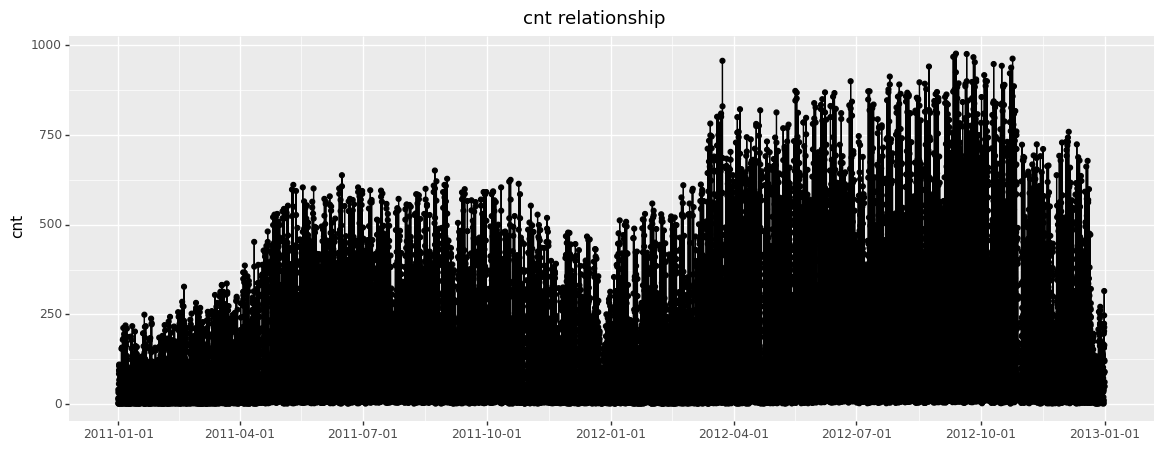

<ggplot: (135306804664)>

In [113]:
# Overall trend of bike sharing demand

(ggplot(bike, aes(bike.index,'cnt')) + geom_point() + geom_line() 
+ labs(y = "cnt", title ="cnt relationship") 
+ theme(figure_size=(14,5))
)

# Demand is increasing over time : trend variable

In [114]:
# Training and Testing data set divide

train_set = bike.loc[bike['year']==2011]
testing_set = bike.loc[bike['year']==2012]

In [115]:
# sample datae plotting for demand analysis
train_set_sample = train_set.iloc[:400]
fig = px.line(train_set_sample, x=train_set_sample.index, y='cnt', markers=True) 
fig.update_xaxes(rangeslider_visible=True)
fig.show()

# There is a demand pattern based on the time. (Daily seasonality)  C(sin_time)
# Jan 1st, 2nd is weekend. Weekend and Weekdays have different demand pattern. (workingday seasonality) C(workingday)
# On weekends the aplitude of seasonal cycle is smaller than weekdays. : Interaction term C(sin_time) * C(workingday)
# There will be a demand pattern based on the date C(month_date)

In [116]:
# Let's build a linear regression model based on the analysis
# Variables : trend, date, time(sin_time)*workingday

Model1 = smf.ols('cnt ~ trend + C(month_date) + C(sin_time)*C(workingday)', data=train_set).fit()
print(Model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     90.15
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:41:54   Log-Likelihood:                -47280.
No. Observations:                8645   AIC:                         9.537e+04
Df Residuals:                    8239   BIC:                         9.824e+04
Df Model:                         405                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [117]:
# Calculating training set MAPE of Model1

mean_absolute_percentage_error(y_true = train_set['cnt'], y_pred = Model1.fittedvalues)

2.6941176952517423

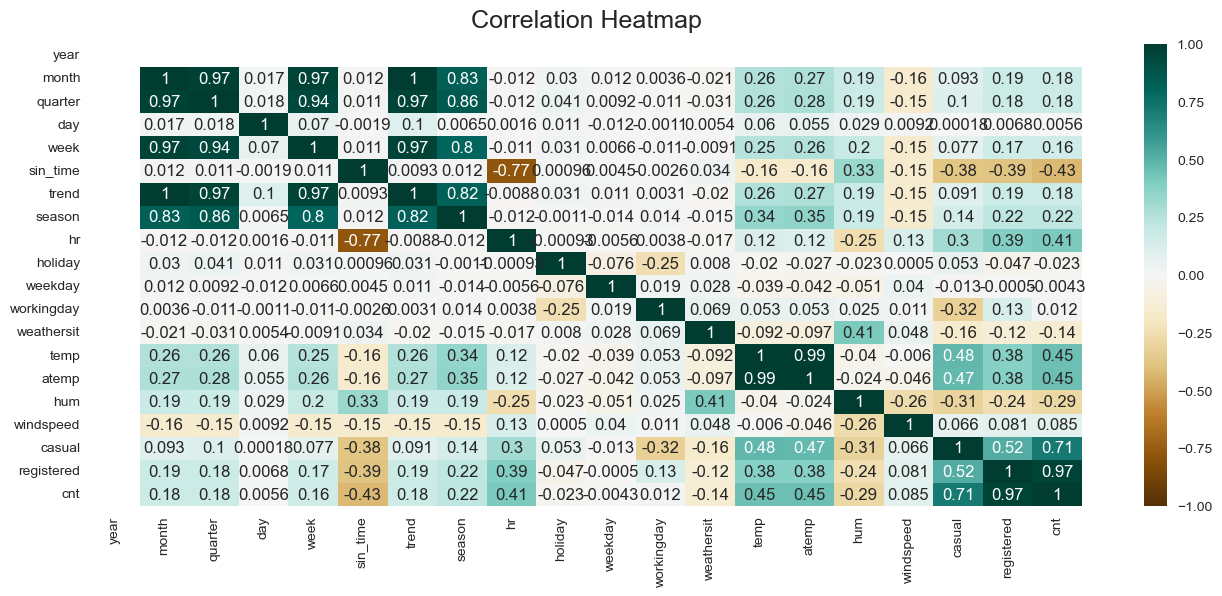

In [118]:
# Let's find variables with high correlation with demand among exogenous variables.

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train_set.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [119]:
# Remove some variables to eliminate multicolinearity issue
train_set.drop(['hr','atemp','month', 'week','casual', 'registered', 'season'], axis=1, inplace=True)

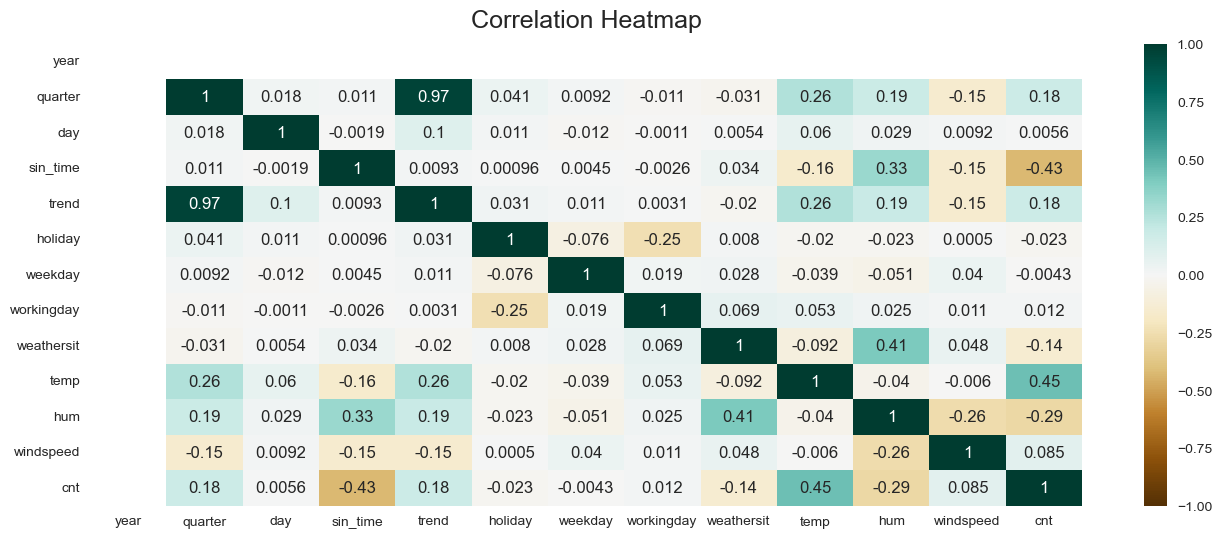

In [120]:
# Check the correlation again

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train_set.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [121]:
# temperature, humidity, hour(sin_time) is the top three highly correlated variables
# Let's add temperature and humidity in the previous model

Model2 = smf.ols('cnt ~ trend + C(month_date) + C(sin_time)*C(workingday) + temp + hum', data=train_set).fit()
print(Model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     98.92
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:42:00   Log-Likelihood:                -46932.
No. Observations:                8645   AIC:                         9.468e+04
Df Residuals:                    8237   BIC:                         9.756e+04
Df Model:                         407                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [122]:
Model2.fittedvalues.describe()

count    8645.000000
mean      143.794448
std       121.906895
min      -121.830448
25%        53.795562
50%       133.534435
75%       214.376723
max       506.239298
dtype: float64

In [123]:
# There are some negative values in demand forecasting, but there is no negative demand, so I will change the negative numbers to 0

train_set['M2'] = Model2.fittedvalues
train_set['M2_modi'] = train_set['M2']
train_set.loc[train_set['M2_modi']<0, 'M2_modi'] = 0

In [124]:
# Calculating training set MAPE of Model2

mean_absolute_percentage_error(y_true = train_set['cnt'], y_pred = Model2.fittedvalues)

2.5166114342980306

In [125]:
# Calculating training set MAPE of Model2 (Modified forecast)

mean_absolute_percentage_error(y_true = train_set['cnt'], y_pred =train_set['M2_modi'])

1.0662941798599974

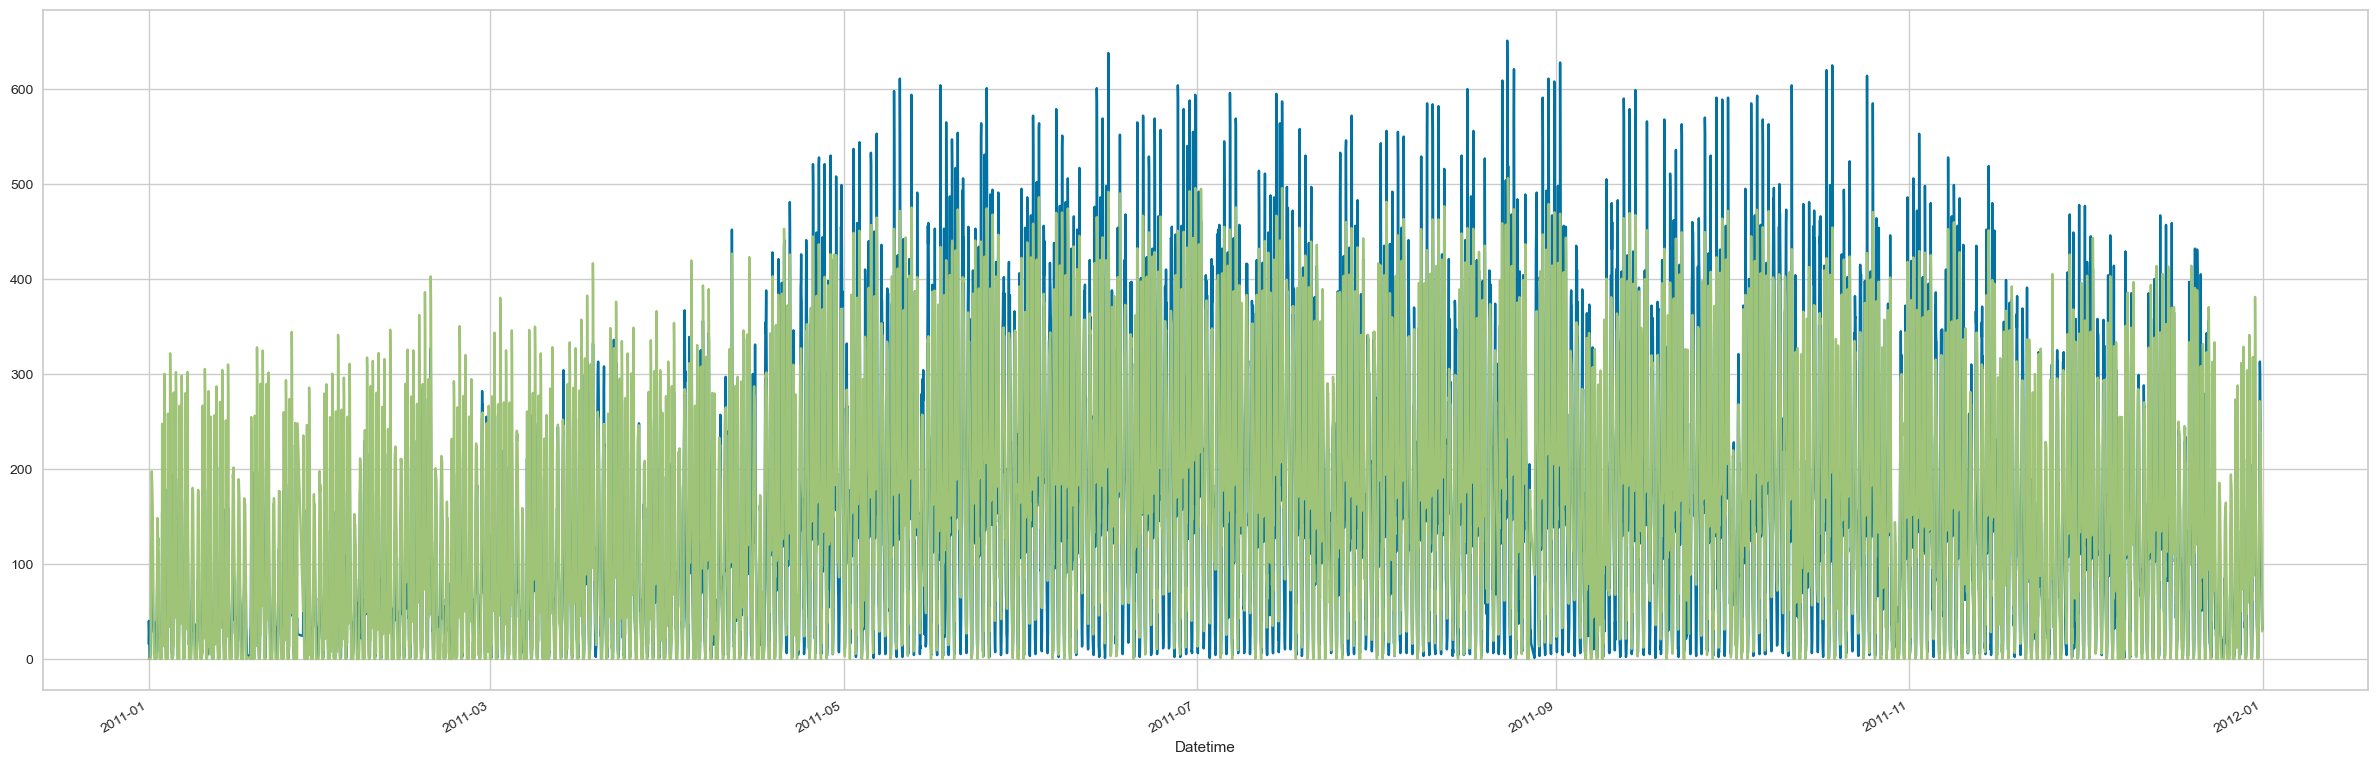

In [126]:
train_set['cnt'].plot(figsize=(30,10))
train_set['M2_modi'].plot()
plt.show()

In [127]:
# Model2.predict(testing_set)

There is 02-29 in 2012 and there is no 02-29 in 2011. So we cannot use the model with C(month_date) variable for our forecasting. <br>
Let's try different way. I will make a new model with C(quarter) variable.

In [128]:
# Model3 with C(quater) variable.

Model3 = smf.ols('cnt ~ trend + C(quarter) + C(sin_time)*C(workingday) + temp + hum', data=train_set).fit()
print(Model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     507.8
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:42:01   Log-Likelihood:                -48851.
No. Observations:                8645   AIC:                         9.780e+04
Df Residuals:                    8597   BIC:                         9.814e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [129]:
# Model 3 prediction in training set

train_set['M3'] = Model3.predict(train_set)
train_set['M3_modi'] = train_set['M3']
train_set.loc[train_set['M3_modi']<0, 'M3_modi'] = 0

In [130]:
# Calculating training set MAPE of Model3 (Modified forecast)

mean_absolute_percentage_error(y_true = train_set['cnt'], y_pred =train_set['M3_modi'])

1.853340284296267

In [131]:
# Predcition for testing dataset

Model3.predict(testing_set)

Datetime
2012-01-01 00:00:00     54.472640
2012-01-01 01:00:00     38.051337
2012-01-01 02:00:00     76.849891
2012-01-01 03:00:00     29.717082
2012-01-01 04:00:00    -34.376968
                          ...    
2012-12-31 19:00:00    266.951668
2012-12-31 20:00:00    201.963453
2012-12-31 21:00:00    163.093285
2012-12-31 22:00:00    135.422877
2012-12-31 23:00:00     90.511652
Length: 8734, dtype: float64

In [132]:
# Modify the prediction (negative to zero)

testing_set['M3'] = Model3.predict(testing_set)
testing_set['M3_modi'] = testing_set['M3']
testing_set.loc[testing_set['M3_modi']<0, 'M3_modi'] = 0

In [133]:
# Calculating testing set MAPE of Model3

mean_absolute_percentage_error(y_true = testing_set['cnt'], y_pred = testing_set['M3_modi'])

2.2030981931960145

### Q21. MAPE on training and testing datasets.

In [134]:
# Training and Testing MAPE of Model3 
print('Training MAPE: ', np.round(mean_absolute_percentage_error(train_set['cnt'], train_set['M3_modi']),2), 
      'Testing MAPE: ' , np.round(mean_absolute_percentage_error(testing_set['cnt'], testing_set['M3_modi']),2) , sep='\n')

Training MAPE: 
1.85
Testing MAPE: 
2.2


### Q22. Visualization of data and foreast for 2012-09-01 to 2012-09-17

In [135]:
# Forecasting for 2012-09-01 to 2012-09-17

forecasting = testing_set.loc[(testing_set['month_date']>='09-01') & (testing_set['month_date']<='09-17')]

In [136]:
Model3.predict(forecasting)
forecasting['M3'] = Model3.predict(forecasting)

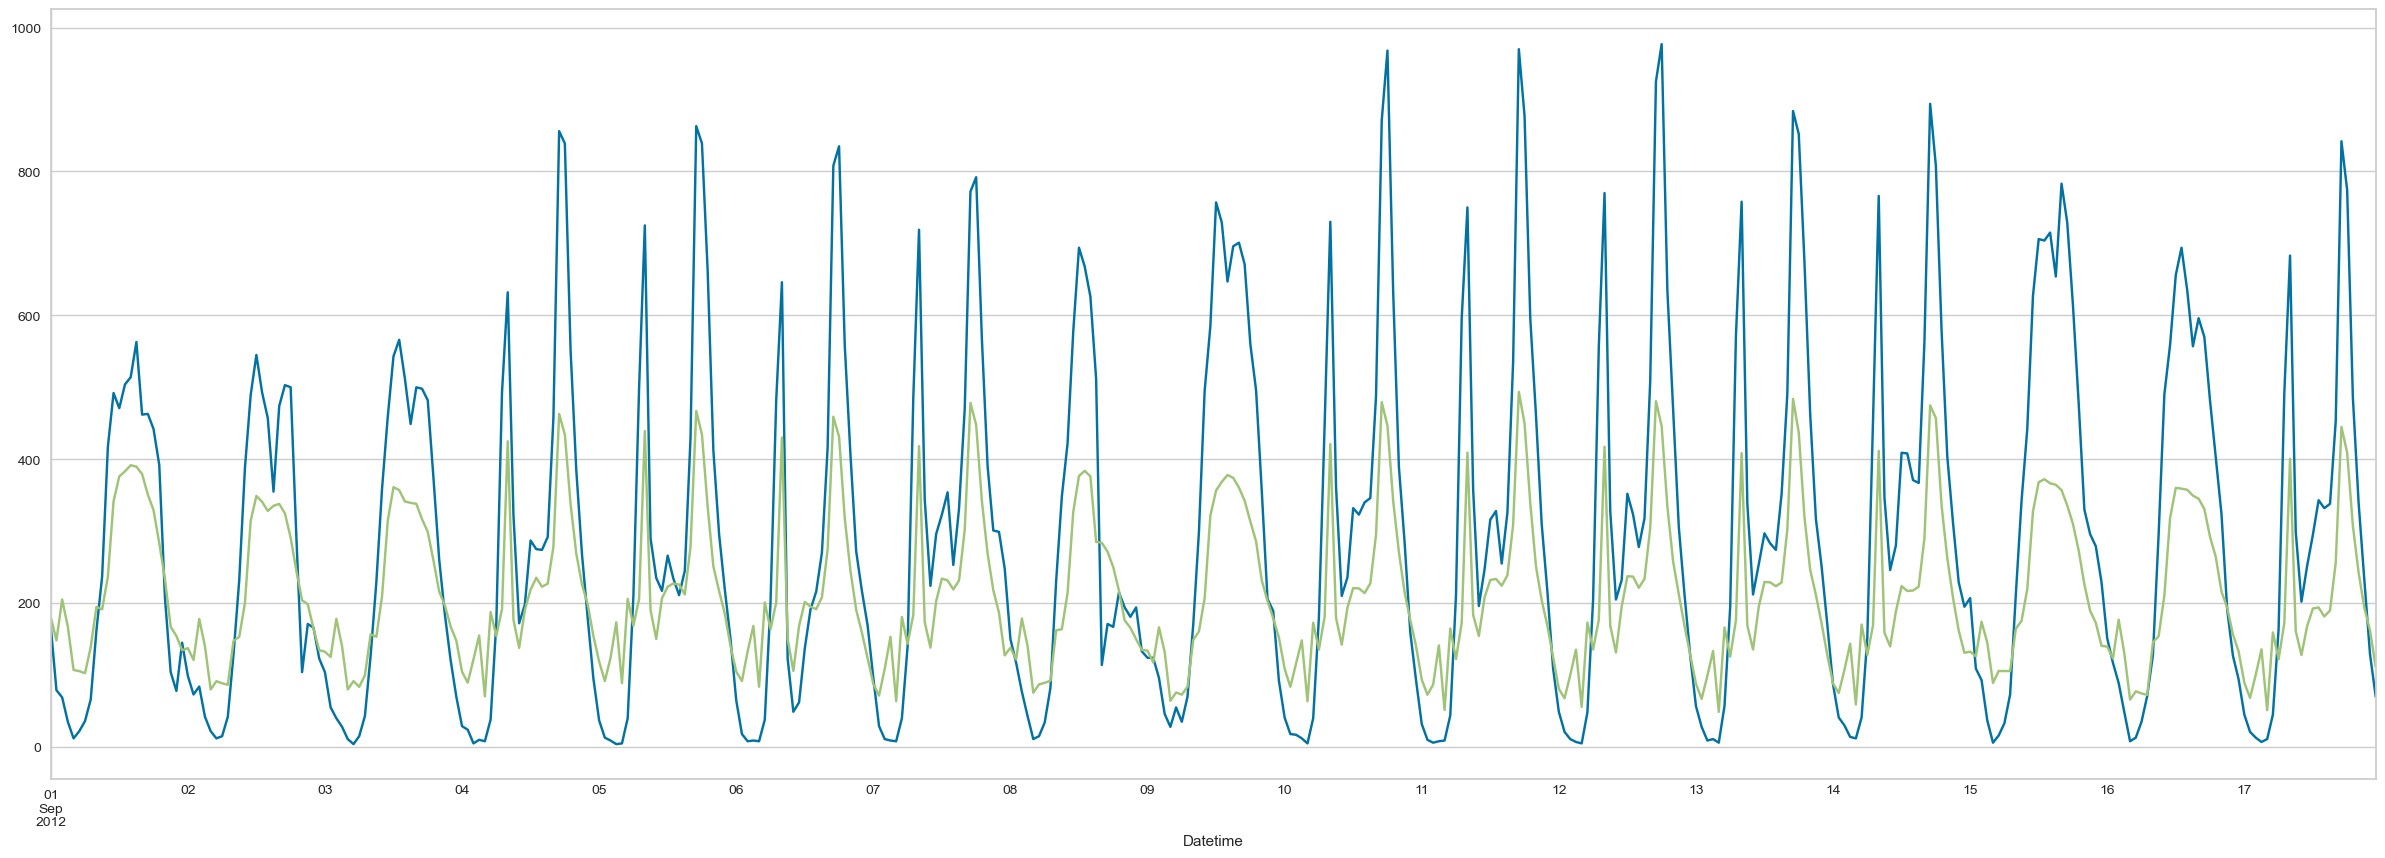

In [137]:
forecasting['cnt'].plot(figsize=(30,10))
forecasting['M3'].plot()
plt.show()

The model does not include the C(month_date) variable, so the prediction does not look good.

In [138]:
Model4 = smf.ols('cnt ~ trend + C(month_date) + C(sin_time) * C(workingday) + temp + hum', data=testing_set).fit()
print(Model4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     123.3
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:42:03   Log-Likelihood:                -50524.
No. Observations:                8734   AIC:                         1.019e+05
Df Residuals:                    8325   BIC:                         1.048e+05
Df Model:                         408                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [139]:
Model4.predict(forecasting)
forecasting['M4'] = Model4.predict(forecasting)

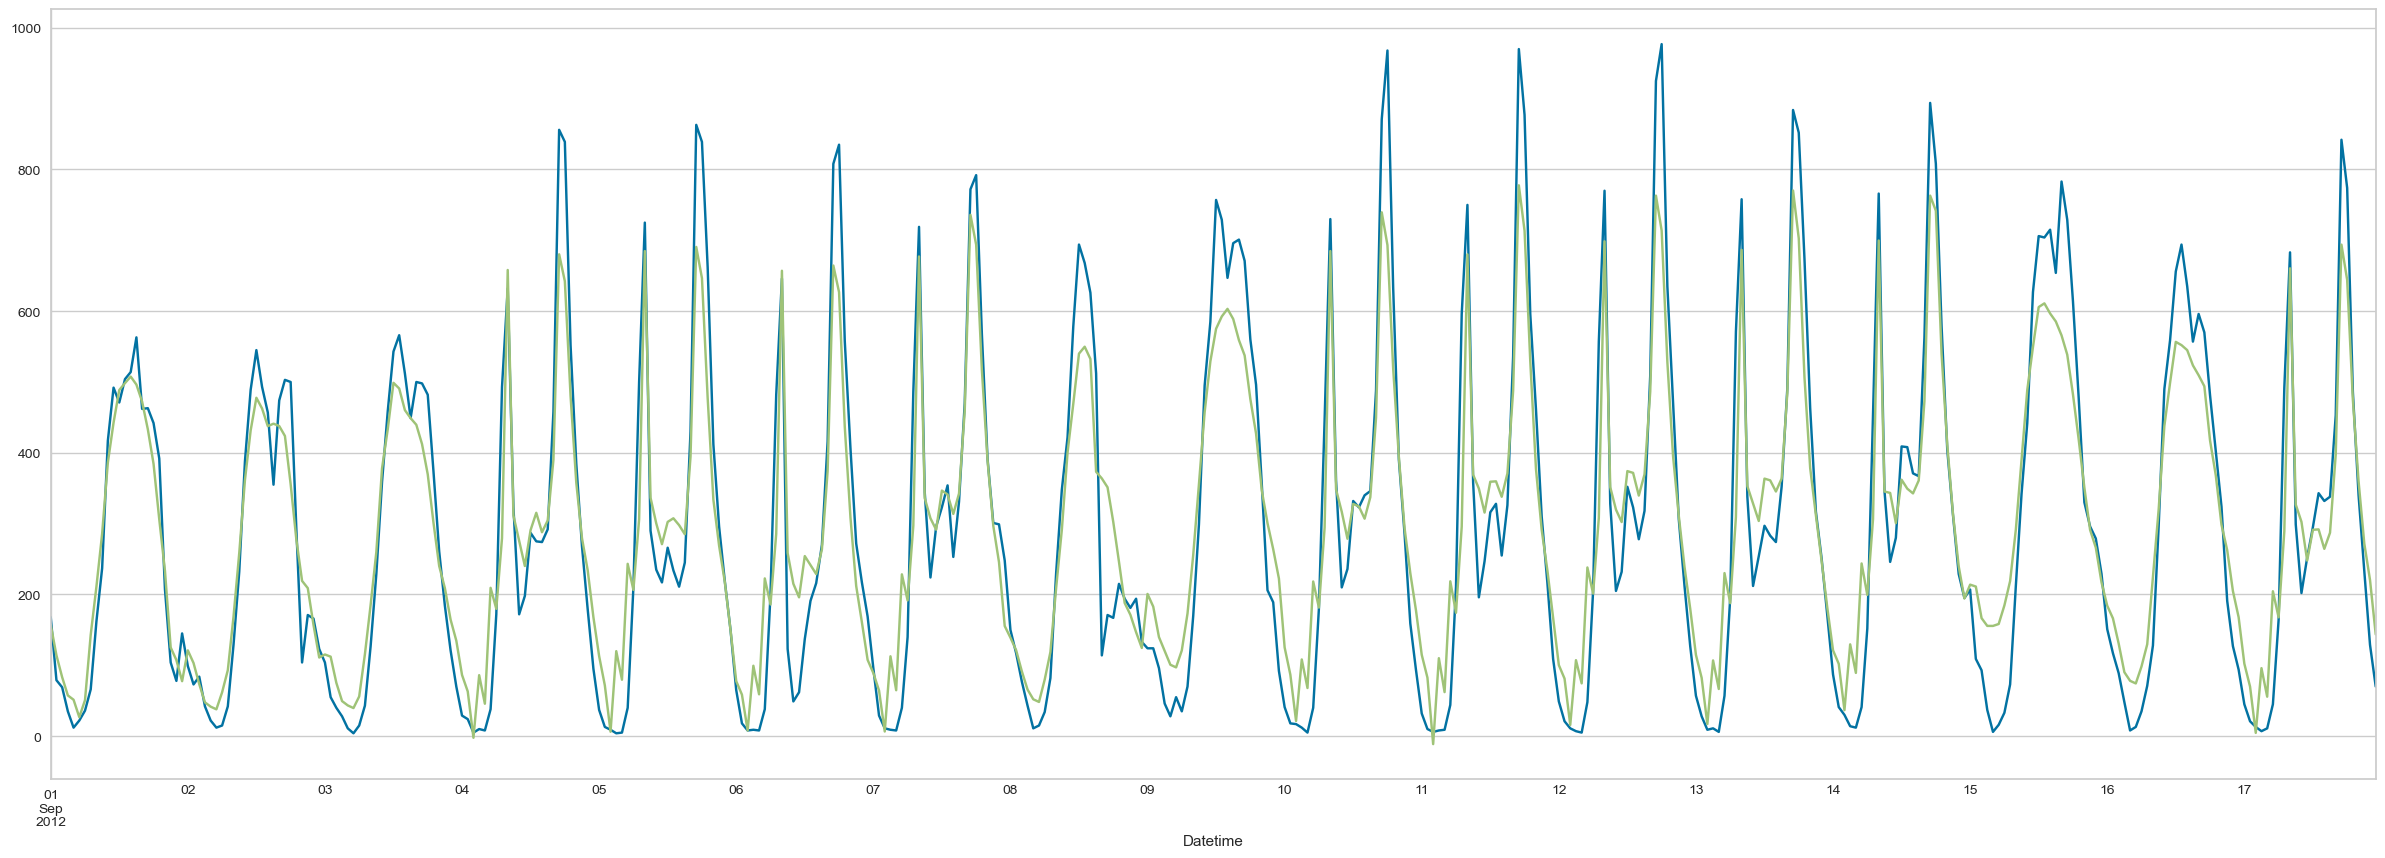

In [140]:
forecasting['cnt'].plot(figsize=(30,10))
forecasting['M4'].plot()
plt.show()

## Machine learning models

In [141]:
# Training and Testing data set divide

train_set = bike.loc[bike['year']==2011]
testing_set = bike.loc[bike['year']==2012]

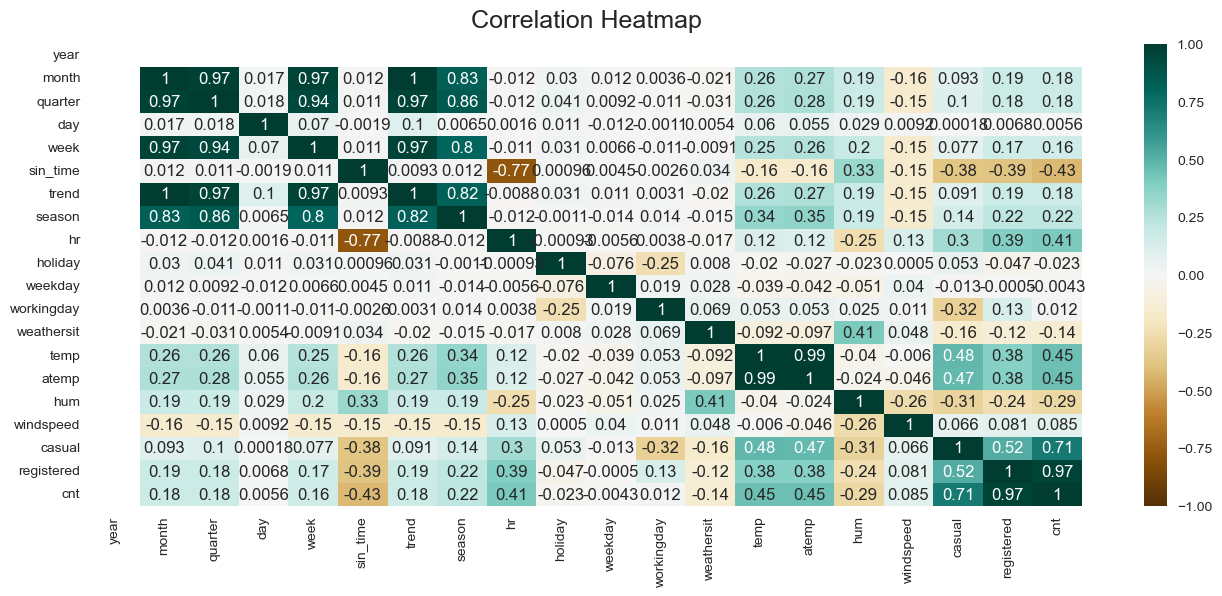

In [142]:
# Let's check the correlation between variables.

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train_set.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [143]:
# Remove some variables to eliminate multicolinearity issue
train_set.drop(['month', 'quarter', 'week', 'season', 'hr','atemp','casual', 'registered'], axis=1, inplace=True)

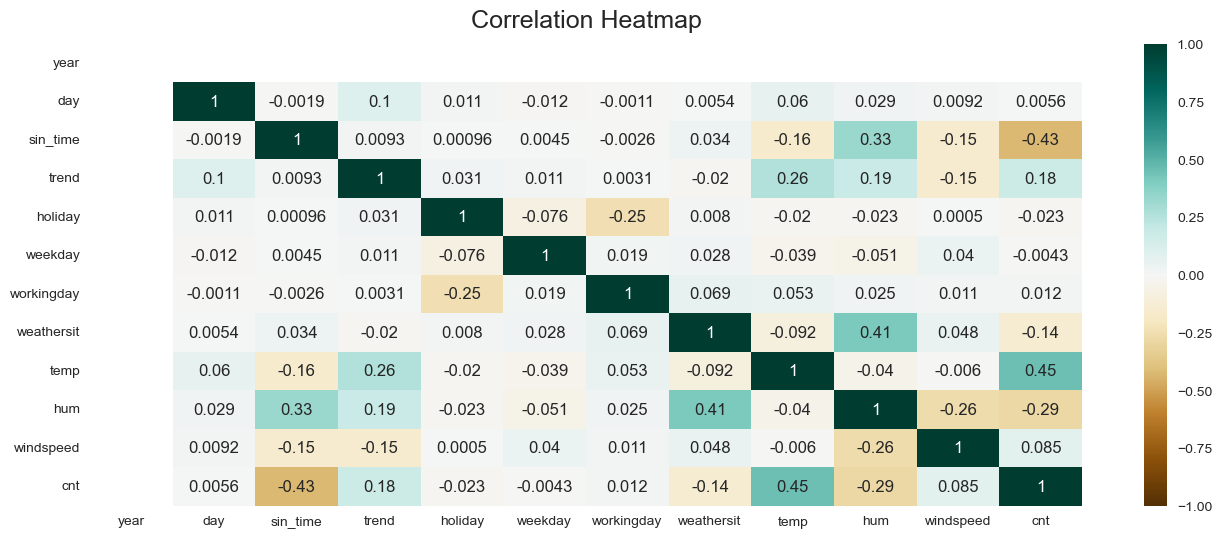

In [144]:
# Check the correlation again

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train_set.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [145]:
from pycaret.regression import *
exp_reg101 = setup(data = train_set, target = 'cnt', session_id=123) 

,Description,Value
0,Session id,123
1,Target,cnt
2,Target type,Regression
3,Data shape,"(8645, 14)"
4,Train data shape,"(6051, 14)"
5,Test data shape,"(2594, 14)"
6,Numeric features,11
7,Date features,1
8,Categorical features,1
9,Preprocess,True


In [146]:
best = compare_models(sort='mape')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,82.5494,12887.5436,113.4504,0.2855,1.2306,2.6926,0.0920
dt,Decision Tree Regressor,63.6585,10344.8321,101.6280,0.4252,1.2284,2.8463,0.0290
rf,Random Forest Regressor,51.0968,5311.8957,72.8310,0.7053,1.0610,2.9969,0.2610
lr,Linear Regression,80.4134,11112.0069,105.3869,0.3833,1.2205,3.0799,0.1070
ridge,Ridge Regression,80.4217,11111.6384,105.3850,0.3833,1.2207,3.0828,0.0310
br,Bayesian Ridge,80.4310,11111.5987,105.3848,0.3834,1.2211,3.0855,0.0280
lightgbm,Light Gradient Boosting Machine,49.7436,5098.9360,71.3373,0.7172,1.0409,3.0873,0.0870
et,Extra Trees Regressor,51.3923,5565.9645,74.5453,0.6912,1.0490,3.0873,0.2070
xgboost,Extreme Gradient Boosting,49.7125,5039.2571,70.9245,0.7203,1.0547,3.1298,0.2220
gbr,Gradient Boosting Regressor,57.4367,6060.1605,77.8172,0.6639,1.0967,3.1407,0.1030


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Base on MAPE criteria, we got several best MAPE models. Let's try top three models. (Huber, DT, RF)

In [147]:
ML1= create_model('huber')

# Huber regression model
# K-fold method : 10 fold Cross Validation
# Average MAPE : 2.6926% 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,83.4099,13211.8134,114.9427,0.3075,1.2535,3.1457
1,79.7539,11771.5463,108.4968,0.2925,1.2677,2.8756
2,80.7342,12251.1843,110.6851,0.3242,1.1994,2.7806
3,86.1405,13937.1462,118.0557,0.2280,1.2108,2.4357
4,80.9051,12382.2790,111.2757,0.2951,1.2071,2.6473
5,79.6285,12357.1449,111.1627,0.3082,1.2036,2.5842
6,82.1890,12504.5447,111.8237,0.3089,1.2478,2.7110
7,88.6196,14903.3396,122.0792,0.2162,1.2424,2.4951
8,79.7615,12023.0691,109.6498,0.3163,1.2725,2.8288


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [148]:
ML2 = create_model('dt') 

# Decision Tree model
# K-fold method : 10 fold Cross Validation
# Average MAPE : 2.8463% 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,66.0363,10135.6172,100.6758,0.4687,1.3464,3.9881
1,64.2694,10385.2248,101.9079,0.3759,1.2057,3.1012
2,57.3421,9679.8678,98.3863,0.4661,1.1514,2.4283
3,64.8744,10278.0612,101.3808,0.4307,1.1701,2.1633
4,63.3140,10133.4529,100.6651,0.4231,1.2062,2.7994
5,60.5785,9823.0512,99.1113,0.4501,1.1895,3.0482
6,59.5752,8863.7802,94.1477,0.5101,1.2227,2.9383
7,64.4496,10724.2678,103.5580,0.4360,1.2335,2.3045
8,68.6678,11627.4512,107.8307,0.3388,1.3280,2.8024


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [149]:
ML3 = create_model('rf') 

# Random Forest model
# K-fold method : 10 fold Cross Validation
# Average MAPE : 2.9969% 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,51.0875,5218.0119,72.2358,0.7265,1.1292,3.8045
1,49.7419,5070.6309,71.2084,0.6953,1.0731,3.0422
2,51.0667,5467.1936,73.9405,0.6984,1.0808,3.2706
3,54.1483,5810.6289,76.2275,0.6781,1.0343,2.5993
4,50.3000,5052.5588,71.0814,0.7124,1.1028,3.3412
5,48.8052,5013.0885,70.8032,0.7194,1.0313,2.6836
6,49.7546,4833.9046,69.5263,0.7329,1.0318,2.6037
7,53.2831,5919.2774,76.9368,0.6887,1.0235,2.7360
8,48.9049,4854.4614,69.6740,0.7240,1.0442,2.6205


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [150]:
# Finalize the model with all training set data
final_M1 = finalize_model(ML1)

In [151]:
# Finalize the model with all training set data
final_M2 = finalize_model(ML2)

In [152]:
# Finalize the model with all training set data
final_M3 = finalize_model(ML3)

In [153]:
# Remove some variables to eliminate multicolinearity issue
testing_set.drop(['month', 'quarter', 'week', 'season', 'hr','atemp','casual', 'registered'], axis=1, inplace=True)

In [154]:
# ML1 model : training set prediction (MAPE 2.68%)
prediction = predict_model(final_M1, data=train_set)
pred1_train = pd.DataFrame(prediction, columns=['prediction_label'])
pred1_train

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,81.4530,12630.3276,112.3847,0.2944,1.2298,2.6815


,prediction_label
0,36.202679
1,13.892714
2,-5.896566
3,-21.244301
4,-34.095769
...,...
8640,181.272557
8641,173.572267
8642,159.523234
8643,141.050814


In [155]:
# ML1 model : testing set prediction (MAPE 1.98%)
prediction = predict_model(final_M1, data=testing_set)
pred1_test = pd.DataFrame(prediction, columns=['prediction_label'])
pred1_test

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,190.6080,69012.5138,262.7023,-0.5814,1.6987,1.9844


,prediction_label
0,-29.540596
1,-51.015081
2,-74.407040
3,-92.247493
4,-103.680831
...,...
8729,112.122594
8730,104.677352
8731,88.304870
8732,72.420805


In [156]:
print('Training MAPE: ', np.round(mean_absolute_percentage_error(train_set['cnt'], pred1_train),2), 
      'Testing MAPE: ' , np.round(mean_absolute_percentage_error(testing_set['cnt'], pred1_test),2) , sep='\n')

Training MAPE: 
2.68
Testing MAPE: 
1.98


In [157]:
pred1 = pd.concat([pred1_train, pred1_test])
pred1.reset_index(inplace=True)

In [158]:
bike1 = bike.reset_index()

<AxesSubplot:>

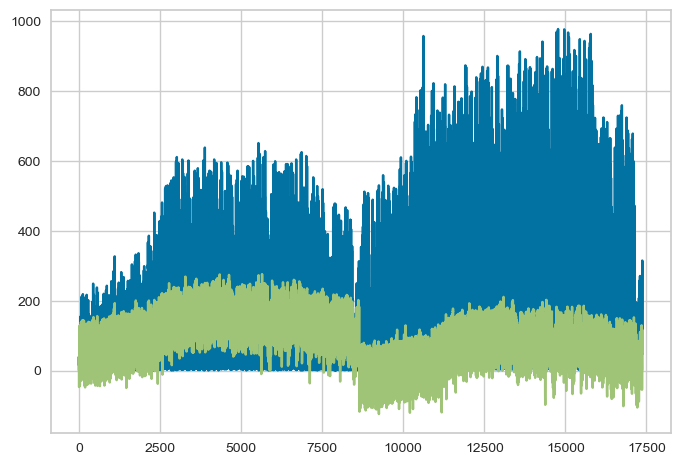

In [159]:
# Visualization of data : This model shows good MAPE value but not good prediction
bike1['cnt'].plot()
pred1['prediction_label'].plot()

In [160]:
# ML2 model : training set prediction (MAPE 0%)
prediction = predict_model(final_M2, data=train_set)
pred2_train = pd.DataFrame(prediction, columns=['prediction_label'])
pred2_train

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


,prediction_label
0,16.0
1,40.0
2,32.0
3,13.0
4,1.0
...,...
8640,92.0
8641,71.0
8642,52.0
8643,38.0


In [161]:
# ML2 model : testing set prediction (MAPE 4.70%)
prediction = predict_model(final_M2, data=testing_set)
pred2_test = pd.DataFrame(prediction, columns=['prediction_label'])
pred2_test

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,147.5330,39024.2747,197.5456,0.1057,1.4953,4.6962


,prediction_label
0,19.0
1,19.0
2,149.0
3,149.0
4,8.0
...,...
8729,273.0
8730,96.0
8731,171.0
8732,197.0


In [162]:
print('Training MAPE: ', np.round(mean_absolute_percentage_error(train_set['cnt'], pred2_train),2), 
      'Testing MAPE: ' , np.round(mean_absolute_percentage_error(testing_set['cnt'], pred2_test),2) , sep='\n')

Training MAPE: 
0.0
Testing MAPE: 
4.7


In [163]:
pred2 = pd.concat([pred2_train, pred2_test])
pred2.reset_index(inplace=True)

<AxesSubplot:>

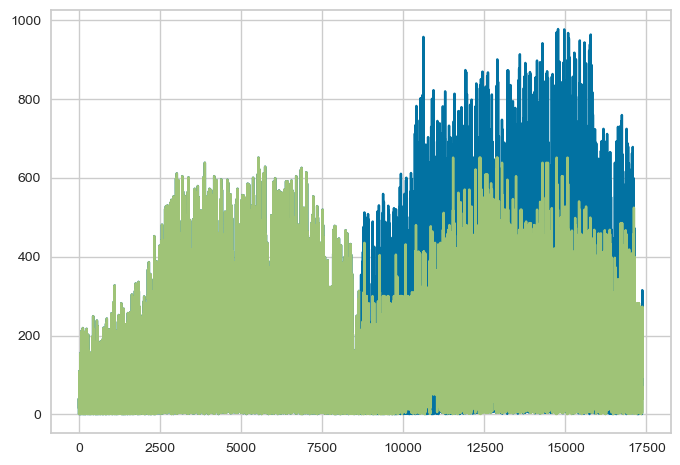

In [164]:
# Visualization of data : This model shows worse testing MAPE value than ML1 model but prediction looks better

bike1['cnt'].plot()
pred2['prediction_label'].plot()

In [165]:
# ML3 model : training set prediction (MAPE 0.85%)
prediction = predict_model(final_M3, data=train_set)
pred3_train = pd.DataFrame(prediction, columns=['prediction_label'])
pred3_train

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,15.6872,574.3099,23.9648,0.9679,0.5612,0.8490


,prediction_label
0,26.19
1,38.57
2,31.46
3,13.14
4,4.70
...,...
8640,102.62
8641,108.73
8642,63.22
8643,44.53


In [166]:
# ML3 model : testing set prediction (MAPE 3.96%)
prediction = predict_model(final_M3, data=testing_set)
pred3_test = pd.DataFrame(prediction, columns=['prediction_label'])
pred3_test

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,131.8390,30560.4915,174.8156,0.2997,1.2534,3.9635


,prediction_label
0,124.55
1,121.15
2,108.24
3,106.58
4,95.06
...,...
8729,187.24
8730,104.14
8731,97.67
8732,100.65


In [167]:
print('Training MAPE: ', np.round(mean_absolute_percentage_error(train_set['cnt'], pred3_train),2), 
      'Testing MAPE: ' , np.round(mean_absolute_percentage_error(testing_set['cnt'], pred3_test),2) , sep='\n')

Training MAPE: 
0.85
Testing MAPE: 
3.96


In [168]:
pred3 = pd.concat([pred3_train, pred3_test])
pred3.reset_index(inplace=True)

<AxesSubplot:>

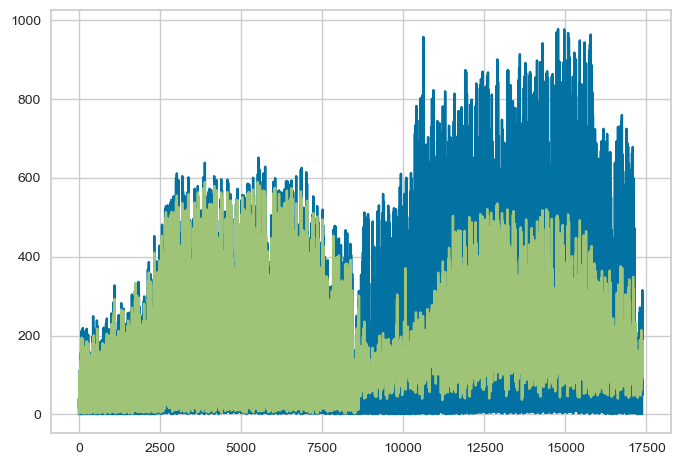

In [169]:
# Visualization of data : This model shows better testing MAPE value than ML2 but not good prediction.
bike1['cnt'].plot()
pred3['prediction_label'].plot()

Among the Machine Learning models, decision tree model performs the best.